In [137]:
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sk
import math
import csv
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random
import matplotlib.pyplot as plt
import pylab as plt
import plotly.plotly as py
import plotly
import plotly.graph_objs as go
from scipy.stats.stats import pearsonr   
from sklearn import linear_model, datasets
import itertools
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
import time 

In [146]:
#########################################################################
##[FUNCTION] data_creation simulates data for a given number of 
## individuals(indiv) over a set amount of time (max_time), and can 
## include as many covariates as desired (number_of_covariates)

## -- need to create the functionality for multiple covariates

#########################################################################


def data_creation2(indiv, max_time, number_of_covariates, Y_full, alpha, beta): 

    columns = ["indiv", "time","U", "A", "Y",  "L1"]
    df = pd.DataFrame(columns = columns)
     
    ## creating an unobserved variable that affects covariates 
    U = np.random.uniform(low = 0.1, high = 1, size = indiv)
            
    for jj in range(0, max_time+1): 
        if jj == 0: 
            x_L = alpha[0] + alpha[5]*U 
            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))

            x_A = beta[0] + beta[1]*L1 
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                 "Y":[math.nan]*indiv, "L1":L1})
            
        elif jj == 1: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"]\
                  [(df.time == jj-1)], [0.0]*indiv, df["A"][(df.time == jj-1)],\
                  [0.0]*indiv, U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv, L1, df["L1"]\
                  [(df.time == jj-1)],df["A"][(df.time == jj-1)], [0.0]*indiv ])), axis = 1)
                         
            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj, "U":U, "A":A,\
                      "Y":[math.nan]*indiv, "L1":L1})
            df = pd.concat([df, temp_df])

        else: 
            x_L = np.sum(alpha*np.transpose(np.array([[1.0]*indiv, df["L1"][(df.time == jj-1)], \
                  df["L1"][(df.time == jj-2)], df["A"][(df.time == jj-1)], \
                  df["A"][(df.time == jj-2)], U])), axis = 1)

            L1 = np.random.binomial(n=1, p = np.exp(x_L)/(1+np.exp(x_L)))


            x_A = np.sum(beta*np.transpose(np.array([[1.0]*indiv,L1,df["L1"][(df.time == jj-1)],\
                  df["A"][(df.time == jj-1)] , df["A"][(df.time == jj-2)]])), axis = 1)

            A = np.random.binomial(n=1, p = np.exp(x_A)/(1+np.exp(x_A)))

            if jj == max_time: 
                # x_Y = U + 0.5
                x_Y = [-1]*indiv + U + A + df.groupby(["indiv"]).A.mean()
                Y = np.random.binomial(n=1, p = np.exp(x_Y)/(1+np.exp(x_Y)))                
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":Y, "L1":L1})
                df = pd.concat([df, temp_df])


            else: 
                temp_df = pd.DataFrame({"indiv":range(0,indiv), "time":jj,"U":U, "A":A, \
                          "Y":[math.nan]*indiv, "L1":L1})
                df = pd.concat([df, temp_df])


    # creating shifted values 
    if Y_full == True:
        for kk in range(1,max_time+1):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
    else:
        for kk in range(1,4):
            df["L1_"+str(kk)] = df.L1.shift(kk)
            df["A_"+str(kk)] = df.A.shift(kk)
            
    df.sort_values(by=['time', 'indiv'], ascending=[True, True])

    return(df); 

In [123]:
#########################################################################
##[FUNCTION] Y_model_creation creates the linear regression model for 
## the observed Ys based on the treatments (A) and covariates (L)  

#########################################################################

def Y_model_creation(df, max_time): 
    temp_df = df[df.time == max_time]
    # train_columns ='+'.join(map(str, np.append(list(df)[0:2],list(df)[6:])))
    train_columns = list(df)[0:2]+list(df)[6:]
    temp_df = temp_df.astype(float)
    # Y_model = smf.ols("Y~"+train_columns, data=temp_df).fit(); 
    Y_model = sm.Logit(np.asarray(temp_df["Y"]), \
                       np.asarray(sm.add_constant(temp_df[train_columns]))).fit(); 
    return(Y_model)

In [124]:
#########################################################################
##[FUNCTION] covariate_model_creation creates the logistic regression 
## for the observed covariate (L) data from the previous covariates 
## and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
## SHOULD THIS BE FOR ALL HISTORY UP TO THAT POINT TO BE MORE 
## ACCURATE WHEN CALCULATING THE EXPECTATION??? 

#########################################################################


def covariate_model_creation(df, max_time): 
    train_columns = ["L1_1", "L1_2", "L1_3", "A_1", "A_2",  "A_3"]
    L1_model = {}
    poly = PolynomialFeatures(1)

    for ii in range(1, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 1: 
            x = temp_df[["L1_1", "A_1"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), poly.fit_transform(x)).fit(); 
        elif ii == 2: 
            x = temp_df[["L1_1", "L1_2", \
                       "A_1", "A_2"]]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # poly.fit_transform(x)).fit(); 
        else: 
            x = temp_df[train_columns]
            # L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       # np.asarray(sm.add_constant())).fit(); 
        L1_model[ii] = sm.Logit(np.asarray(temp_df["L1"]), \
                       poly.fit_transform(x)).fit(); 
    return(L1_model)

In [95]:
#########################################################################
##[FUNCTION] treatment_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) 

## -- need to create the functionality for multiple covariates
#########################################################################


def treatment_model_creation(df, max_time): 
    train_columns = ["L1", "L1_1", "L1_2", "A_1", "A_2", "A_3"]
    A_model = {}
    poly = PolynomialFeatures(1)
            
    for ii in range(0, (max_time+1)): 
        temp_df = df[df.time == ii] 
        if ii == 0: 
            x = temp_df[["L1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), sm.add_constant(x, has_constant = "add")).fit()
        elif ii == 1: 
            x = temp_df[["L1", "L1_1", "A_1"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        elif ii == 2:
            x = temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
        else: 
            x = temp_df[train_columns]
            A_model[ii] = sm.Logit(np.asarray(temp_df["A"]), poly.fit_transform(x)).fit()
    return(A_model)


In [131]:
#########################################################################
##[FUNCTION] simulation_run calculates the causal effect over an  
## established number of repetitions using the models for outcome (Y) 
## and the covariates (L) 

## -- need to create the functionality for multiple covariates

#########################################################################


def simulation_run2(df, Y_model, L1_model_df, max_time, Y_full, test_value): 
    reps = 10000
    final_results = np.empty(reps) 
    
    L_model = covariate_model_creation(df, max_time)
    poly = PolynomialFeatures(1)

    ### establishing treatment of interest
    A_test = [test_value]*(max_time+1) 

    values = pd.DataFrame(np.random.choice(np.array(df["L1"][df["time"] == 0]), reps))
    prod = np.empty(reps) 
    
    prod[np.where(values[0] == 0)] = 1-np.mean(list(df["L1"][df["time"] == 0]))
    prod[np.where(values[0] != 0)] = np.mean(list(df["L1"][df["time"] == 0]))

    x = np.transpose(np.array([list(values[0]),[A_test[0]]*reps]))
    values[1] = L_model[1].predict(poly.fit_transform(x))
    #np.sum(np.array([L1_model_df.ix[0,][i] for i in [1,2,5]])*np.transpose(\
                # np.array([[1.0]*reps,list(values[0]),[A_test[0]]*reps])), axis = 1)
    
    p_v = sp.special.expit(values[1])
    values[1] = np.random.binomial(n=1, p = p_v)
    prod = prod*p_v
    
    x = np.transpose(np.array([list(values[1]),list(values[0]), [A_test[1]]*reps, [A_test[0]]*reps]))
    values[2] = L_model[2].predict(poly.fit_transform(x))
                # np.sum(np.array([L1_model_df.ix[1,][i] for i in [1,2,3,5,6]])*\
                # np.transpose(np.array([[1.0]*reps, list(values[1]),list(values[0]), \
                # [A_test[1]]*reps, [A_test[0]]*reps])), axis = 1 )
    p_v = sp.special.expit(values[2]) 
    values[2] = np.random.binomial(n=1, p=p_v)
    prod = prod*p_v
    
                                                               

    for jj in range(3, max_time+1):
        x = np.transpose(np.array([list(values[jj-1]),\
                     list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     [A_test[jj-2]]*reps, [A_test[jj-3]]*reps]))
        values[jj] = L_model[jj].predict(poly.fit_transform(x))
                     # np.sum(np.array([L1_model_df.ix[jj-1,][i] for i in range(1,8)])\
                     # *np.transpose(np.array([[1.0]*reps,list(values[jj-1]),\
                     # list(values[jj-2]), list(values[jj-3]), [A_test[jj-1]]*reps, \
                     # [A_test[jj-2]]*reps, [A_test[jj-3]]*reps])), axis = 1)
        p_v = sp.special.expit(values[jj]) 
        values[jj] = np.random.binomial(n=1, p=p_v)
        prod = prod*p_v

    if Y_full == "TRUE": 
        Y_A = [A_test]*reps
        Y_L = np.array(values)
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8,10,12,14,16,18,20,22,24]]), \
                axis = 1)+np.sum([Y_model.params[i] for i in \
                [2,3,5,7,9,11,13,15,17,19,21,23]]*Y_L, axis = 1)
        Y_exp = sp.special.expit(Y_exp)
        
    else: 
        Y_A = [A_test*4]*reps
        Y_L = np.array([values[0], values[1], values[2], values[3], values[4]])
        Y_exp = np.array(Y_model.params[0])*([1.0]*reps) + np.sum(Y_A*np.array(\
                [Y_model.params[i] for i in [1,4,6,8]]), axis = 1)+np.sum(\
                [Y_model.params[i] for i in [2,3,5,7]]*Y_L, axis = 1)
        Y_exp = (np.exp(Y_exp)/(1+np.exp(Y_exp)))

    return(np.mean(prod*Y_exp)) 

In [7]:
#########################################################################
##[FUNCTION] pi_function creates the w_m function given the following:
## the alpha model of A_{m,i}, the dataframe, the time (m), and an 
## indicator of whether this is the correct or incorrect model 

## do I need to do something in here like 1-expit for those A_j == 0?? 
## i.e. what I did in the last line here 
#########################################################################

def pi_function(m, alpha_model, df, indiv, alpha_wrong): 
    product = [1]*indiv
    for jj in range(3, m+1):
        if alpha_wrong[jj] == False: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1", "L1_1", "L1_2", "A_1", \
                "A_2"]], has_constant='add'))
        else: 
            x = alpha_model[jj].predict(sm.add_constant(df[df.time == jj][["L1_3", \
                "A_3"]], has_constant='add'))
        product = product*x
    
    x = np.array(np.divide([1]*indiv, product))
    x[np.where(df[df.time == m]["A_1"] == 0.0)] = 1 - x[np.where(df[df.time == m]["A_1"] == 0.0)]
    return(x)    

In [8]:
#########################################################################
##[FUNCTION] alpha_model_creation creates the logistic regression 
## for the observed treatment (A) data from the current and previous 
## covariates and the previous treatments (A) over all time periods and
## individuals 

## -- need to create the functionality for multiple covariates
#########################################################################


def alpha_model_creation(df, wrong): 
    temp_df = df[df["time"]>2.0]
    if wrong == True:
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1_3", "A_3"]], has_constant='add'))).fit()

    else: 
        alpha_model = sm.Logit(np.asarray(temp_df.A),np.asarray(sm.add_constant(\
                      temp_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant='add'))).fit()

    return(alpha_model)  

In [9]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]

    while(time_counter > 3.0): 
        
        time_df = df.loc[df.time == time_counter-1]
        time_df["T"] = np.array(T)
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi 
        if wrong_s_model == "TRUE":
            train_columns = list(time_df)[0:1]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1],["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
            y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
            z = '+'.join(map(str, y))
            reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
            reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))

        time_df = time_df.astype(float)
        S_model = smf.ols("T~"+reg_columns, data=time_df).fit()
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
                
        elif test_value == 0: 
            if wrong_alpha_model == "TRUE":
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))

        time_df["pi"] = pi2
        T = sp.special.expit(S_model.predict(time_df[train_columns]))
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    
    return(np.nanmean(T), values)  

In [10]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            # train_columns = list(time_df)[0:1]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
            # reg_columns = '+'.join(map(str, np.append(list(time_df)[0:1], ["pi"])))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model == True:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model == True:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model.predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [11]:
#########################################################################
##[FUNCTION] DR_estimate_creation calculates the causal effect for a 
## given treatment of interest (test_value), including an indicator 
## of whether the correct or incorrect model is being used 

#########################################################################

def DR_estimate_creation_bin_time(test_value, max_time, df, indiv, wrong_alpha_model, wrong_s_model, alpha_model, int_term):
    
    A_test = [test_value]*indiv 
    model_df = pd.DataFrame(columns = ["time", "beta_0", "beta_1", "beta_2", \
                "beta_3", "beta_4", "beta_5", "beta_6", "phi"])
    time_counter = max_time+1
    T = df[df.time == max_time]["Y"]
    
    poly = sk.preprocessing.PolynomialFeatures(interaction_only = True)

    while(time_counter > 3.0): 
        time_df = df.loc[df.time == time_counter-1]
        pi = pi_function(time_counter-1, alpha_model, df, indiv, wrong_alpha_model) 
        time_df["pi"] = pi
        if wrong_s_model[time_counter-1] == True:
            train_columns = list(time_df)[0:2] + list(time_df)[12:14]+["pi"]
            reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2],np.append(list(time_df)[12:14], ["pi"]))))
        else: 
            train_columns = list(time_df)[0:2] + list(time_df)[6:10]+["pi"]
            if int_term == True:
                x = list(itertools.combinations(np.append(list(time_df)[0:2], list(time_df)[6:10]), 2))
                y = ['*'.join(map(str, np.array([x[i][0], x[i][1]]))) for i in range(len(x))]
                z = '+'.join(map(str, y))
                reg_mid_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
                reg_columns = '+'.join(map(str, np.array([reg_mid_columns, z])))
            else:
                reg_columns = '+'.join(map(str, np.append(list(time_df)[0:2], np.append(list(time_df)[6:10],["pi"]))))
        time_df = time_df.astype(float)
        
        formula = "T~"+reg_columns 
        glm_model = smf.glm(formula = formula, data = time_df, family=sm.families.Binomial(link=sm.families.links.logit))
        try:
             glm_results = glm_model.fit()
        except Exception as ex:
            return(float("nan"), float("nan"))
        
        pi2 = pi_function(time_counter-2, alpha_model, df, indiv, wrong_alpha_model)
        
        time_df["A"] = np.array(A_test)
        
        if test_value == 1: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add"))
            else:
                pi2 = pi2*alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", \
                    "A_2"]], has_constant = "add"))
        
        elif test_value == 0: 
            if wrong_alpha_model[time_counter-1] == True:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1_3", "A_3"]], has_constant = "add")))
            else:
                pi2 = pi2*(1-alpha_model[time_counter-1].predict(sm.add_constant(time_df[["L1", "L1_1", "L1_2", "A_1", "A_2"]], has_constant = "add")))
            

        time_df["pi"] = pi2
        T = glm_results.predict(time_df[train_columns])
        time_counter = time_counter-1
    
    values = np.array([np.mean(df.Y), np.mean(df.A), np.mean(df.L1), np.mean(df.U), \
             pearsonr(df.Y[df.time == 11], df.A[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.L1[df.time == 11])[0], \
             pearsonr(df.Y[df.time == 11], df.U[df.time == 11])[0], \
             pearsonr(df.A, df.L1)[0], pearsonr(df.U, df.L1)[0], pearsonr(df.A, df.U)[0]])
    return(np.nanmean(T), values)  

In [17]:
## NEW OFFICIAL ALPHA AND BETA FOR EVERYTHING 
# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
# ALPHA = [ 0.58986656  0.95344212 -0.89822429 -0.95566697  0.67520365  2.46365403]
# BETA = [ 0.17868818  0.89069712  0.89037635  0.20497534  0.10442911]

In [85]:
indiv = 1000 
max_time = 11
num_sims = 10
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]
df = data_creation2(indiv, max_time, 1, "TRUE", alpha, beta) 
alpha_model = alpha_model_creation(df,False)
[treatdr1, values] =  DR_estimate_creation_bin(1.0, max_time, df, indiv, False, False, alpha_model)
[treatdr0, values] =  DR_estimate_creation_bin(0.0, max_time, df, indiv, False, False, alpha_model)
treatdr1 - treatdr0

Optimization terminated successfully.
         Current function value: 0.409421
         Iterations 6


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



-0.018681009066687126

In [147]:
## CONSTANTS 
alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 1000
# alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
# beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

results_effect_time = pd.DataFrame(columns = ["treatment_g1", "treatment_g0", "differenceg", 
                                            "treatment_dr1", "treatment_dr0", "differencedr",\
                "meanY", "meanA", "meanL1","meanU","corrYA", "corrYL1", "corrYU", \
                "corrAL1", "corrUL1", "corrAU"])

time_dr = 0 
time_g = 0 
time_df = 0 

alpha_model_right = [False]*12
s_model_right = [False]*12
alpha_model_good = {}

for ii in range(0, num_sims): 
    print(ii) 
    start_time = time.time()
    df = data_creation2(indiv, max_time, 1, True, alpha, beta)
    time_df = time_df + time.time() - start_time
     
    #Y_model = Y_model_creation(df, max_time)
    #L1_model_df = covariate_model_creation(df, max_time)
    # treatg1 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 1)
    # treatg0 = simulation_run2(df, Y_model, L1_model_df, max_time, "TRUE", 0)
    # results_g_form_df.loc[len(results_g_form_df)+1] = [treatg1, treatg0, treatg1-treatg0]
    #time_g = time_g + time.time()-start_time
    
    # start_time = time.time()
    # for kk in range(0,max_time+1):
        # alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    # [treatdr1_bin, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    # [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, alpha_model_right, s_model_right, alpha_model_good, False)
    # time_dr = time_dr + time.time() - start_time

    # results_effect_time.loc[len(results_effect_time)+1] = [treatg1, treatg0, treatg1-treatg0, treatdr1_bin, treatdr0_bin, treatdr1_bin - treatdr0_bin]+list(values) 
    
# results_effect_df2.to_csv("W_EFFECT_RESULTS2")
#results_g_form_df.to_csv("G_FORM_RESULTS_FINAL")
#results_dr_bin_df.to_csv("DR_BIN_EST_RESULTS_FINAL")
#results_dr_bin_int_df.to_csv("DR_BIN_INT_EST_RESULTS_FINAL")

0
Optimization terminated successfully.
         Current function value: 0.571161
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.327901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333098
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384592


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.543814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370204


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.555904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382047


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.540337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488788
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361205


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.567487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391920


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.544020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369175


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.549482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359181


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.528922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389535


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.545803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.553737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532857
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.336545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371830


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.559269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345143
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368950

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.531739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324180
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377421

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.553938
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.577370
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372969

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.563718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378420

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.552718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.569385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369852
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330333

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.572218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355431
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361621

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.570269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369958

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.565834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355510

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.552692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378745

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.550022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360794
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.510841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.548571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370660

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.558426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.525770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345299

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



25
Optimization terminated successfully.
         Current function value: 0.550913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349515

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



26
Optimization terminated successfully.
         Current function value: 0.563926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.309588
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360178

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



27
Optimization terminated successfully.
         Current function value: 0.560762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341962
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



28
Optimization terminated successfully.
         Current function value: 0.559317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510297
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408596

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



29
Optimization terminated successfully.
         Current function value: 0.546797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500127
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336461

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



30
Optimization terminated successfully.
         Current function value: 0.528562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507434
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343232
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



31
Optimization terminated successfully.
         Current function value: 0.562449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365748

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



32
Optimization terminated successfully.
         Current function value: 0.557785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484415
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



33
Optimization terminated successfully.
         Current function value: 0.555363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352926

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



34
Optimization terminated successfully.
         Current function value: 0.589421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



35
Optimization terminated successfully.
         Current function value: 0.574398
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315385

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



36
Optimization terminated successfully.
         Current function value: 0.552030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383517

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



37
Optimization terminated successfully.
         Current function value: 0.544240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524447
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



38
Optimization terminated successfully.
         Current function value: 0.584285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344451

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



39
Optimization terminated successfully.
         Current function value: 0.541467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516038
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



40
Optimization terminated successfully.
         Current function value: 0.554178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.308612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346744

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



41
Optimization terminated successfully.
         Current function value: 0.563866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357503
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367756

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



42
Optimization terminated successfully.
         Current function value: 0.570613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



43
Optimization terminated successfully.
         Current function value: 0.555067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524729
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332737
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346340
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



44
Optimization terminated successfully.
         Current function value: 0.532465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335986

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



45
Optimization terminated successfully.
         Current function value: 0.539173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331246
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393899

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



46
Optimization terminated successfully.
         Current function value: 0.563506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353268
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395648

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



47
Optimization terminated successfully.
         Current function value: 0.538373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375398
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354923

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



48
Optimization terminated successfully.
         Current function value: 0.564228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371100

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



49
Optimization terminated successfully.
         Current function value: 0.561821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495741
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348159

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



50
Optimization terminated successfully.
         Current function value: 0.568320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



51
Optimization terminated successfully.
         Current function value: 0.538693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.327925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368558

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



52
Optimization terminated successfully.
         Current function value: 0.550431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



53
Optimization terminated successfully.
         Current function value: 0.513812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.346968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341296

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



54
Optimization terminated successfully.
         Current function value: 0.555200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362733

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



55
Optimization terminated successfully.
         Current function value: 0.575293
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373896

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



56
Optimization terminated successfully.
         Current function value: 0.563359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522869
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.341900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387681

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



57
Optimization terminated successfully.
         Current function value: 0.561334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389512

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



58
Optimization terminated successfully.
         Current function value: 0.548679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.334415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



59
Optimization terminated successfully.
         Current function value: 0.550170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



60
Optimization terminated successfully.
         Current function value: 0.571302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



61
Optimization terminated successfully.
         Current function value: 0.580739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369652
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



62
Optimization terminated successfully.
         Current function value: 0.546663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500007
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



63
Optimization terminated successfully.
         Current function value: 0.576851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.313254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370118

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



64
Optimization terminated successfully.
         Current function value: 0.557045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386270

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



65
Optimization terminated successfully.
         Current function value: 0.570454
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483839
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366379

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



66
Optimization terminated successfully.
         Current function value: 0.575966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



67
Optimization terminated successfully.
         Current function value: 0.565373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358931

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



68
Optimization terminated successfully.
         Current function value: 0.552507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530408
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328942
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361494

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



69
Optimization terminated successfully.
         Current function value: 0.526163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335828

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



70
Optimization terminated successfully.
         Current function value: 0.527888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



71
Optimization terminated successfully.
         Current function value: 0.551978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332698
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361608

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



72
Optimization terminated successfully.
         Current function value: 0.560011
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481310
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



73
Optimization terminated successfully.
         Current function value: 0.560754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.296741
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345464

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



74
Optimization terminated successfully.
         Current function value: 0.557028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.333522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390628

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



75
Optimization terminated successfully.
         Current function value: 0.537223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.344280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357058

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



76
Optimization terminated successfully.
         Current function value: 0.577961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.303718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



77
Optimization terminated successfully.
         Current function value: 0.555978
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356271
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371850

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



78
Optimization terminated successfully.
         Current function value: 0.576419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346489

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



79
Optimization terminated successfully.
         Current function value: 0.522110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333691
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.345905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369331

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



80
Optimization terminated successfully.
         Current function value: 0.586022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368383

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



81
Optimization terminated successfully.
         Current function value: 0.556339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343950
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355770

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



82
Optimization terminated successfully.
         Current function value: 0.558177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



83
Optimization terminated successfully.
         Current function value: 0.565249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332166
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361974

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



84
Optimization terminated successfully.
         Current function value: 0.548410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



85
Optimization terminated successfully.
         Current function value: 0.539418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



86
Optimization terminated successfully.
         Current function value: 0.526079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350745
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377950

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



87
Optimization terminated successfully.
         Current function value: 0.546543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.332453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373386

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



88
Optimization terminated successfully.
         Current function value: 0.576558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366180
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341760

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



89
Optimization terminated successfully.
         Current function value: 0.541697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360617
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321903

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



90
Optimization terminated successfully.
         Current function value: 0.575326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513737
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356204
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.354655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.408403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



91
Optimization terminated successfully.
         Current function value: 0.551632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353601
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321372

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



92
Optimization terminated successfully.
         Current function value: 0.559562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404597

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



93
Optimization terminated successfully.
         Current function value: 0.558341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.312368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



94
Optimization terminated successfully.
         Current function value: 0.561967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340929
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



95
Optimization terminated successfully.
         Current function value: 0.570851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



96
Optimization terminated successfully.
         Current function value: 0.556581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517110
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



97
Optimization terminated successfully.
         Current function value: 0.583197
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373765
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



98
Optimization terminated successfully.
         Current function value: 0.561290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



99
Optimization terminated successfully.
         Current function value: 0.558991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358654
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



100
Optimization terminated successfully.
         Current function value: 0.544752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525597
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



101
Optimization terminated successfully.
         Current function value: 0.598704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



102
Optimization terminated successfully.
         Current function value: 0.561539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40621

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



103
Optimization terminated successfully.
         Current function value: 0.561765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36992

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



104
Optimization terminated successfully.
         Current function value: 0.554855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.319301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349801
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36744

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



105
Optimization terminated successfully.
         Current function value: 0.563712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508576
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.328371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351073
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34337

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



106
Optimization terminated successfully.
         Current function value: 0.562027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.416537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32388

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



107
Optimization terminated successfully.
         Current function value: 0.552300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39476

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



108
Optimization terminated successfully.
         Current function value: 0.568254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33091

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



109
Optimization terminated successfully.
         Current function value: 0.533019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356195
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356829
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348582
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34174

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



110
Optimization terminated successfully.
         Current function value: 0.555875
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497977
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



111
Optimization terminated successfully.
         Current function value: 0.552236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530616
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370570
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38676

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



112
Optimization terminated successfully.
         Current function value: 0.571523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39654

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



113
Optimization terminated successfully.
         Current function value: 0.563758
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.308294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36211

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



114
Optimization terminated successfully.
         Current function value: 0.592060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511728
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



115
Optimization terminated successfully.
         Current function value: 0.556477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358002
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40121

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



116
Optimization terminated successfully.
         Current function value: 0.579165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339611
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36807

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



117
Optimization terminated successfully.
         Current function value: 0.565450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36131

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



118
Optimization terminated successfully.
         Current function value: 0.578177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



119
Optimization terminated successfully.
         Current function value: 0.538997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32882

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



120
Optimization terminated successfully.
         Current function value: 0.555548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38674

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



121
Optimization terminated successfully.
         Current function value: 0.560703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367085
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350356
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35273

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



122
Optimization terminated successfully.
         Current function value: 0.554420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.465191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375287
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



123
Optimization terminated successfully.
         Current function value: 0.555377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368223
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39868

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



124
Optimization terminated successfully.
         Current function value: 0.563519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347667
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40411

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



125
Optimization terminated successfully.
         Current function value: 0.562408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40036

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



126
Optimization terminated successfully.
         Current function value: 0.547135
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33706

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



127
Optimization terminated successfully.
         Current function value: 0.561543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494096
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352633
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



128
Optimization terminated successfully.
         Current function value: 0.563098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509577
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37097

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



129
Optimization terminated successfully.
         Current function value: 0.539508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370210
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40017

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



130
Optimization terminated successfully.
         Current function value: 0.562730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



131
Optimization terminated successfully.
         Current function value: 0.548137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36881

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



132
Optimization terminated successfully.
         Current function value: 0.565382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515401
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



133
Optimization terminated successfully.
         Current function value: 0.582255
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508453
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38340

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



134
Optimization terminated successfully.
         Current function value: 0.583848
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34340

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



135
Optimization terminated successfully.
         Current function value: 0.536594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



136
Optimization terminated successfully.
         Current function value: 0.539009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38956

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



137
Optimization terminated successfully.
         Current function value: 0.547478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38960

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



138
Optimization terminated successfully.
         Current function value: 0.558296
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



139
Optimization terminated successfully.
         Current function value: 0.539448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373136
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



140
Optimization terminated successfully.
         Current function value: 0.562591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39519

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



141
Optimization terminated successfully.
         Current function value: 0.541084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32702

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



142
Optimization terminated successfully.
         Current function value: 0.571265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516307
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37684

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



143
Optimization terminated successfully.
         Current function value: 0.575775
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37639

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



144
Optimization terminated successfully.
         Current function value: 0.563967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.430131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37288

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



145
Optimization terminated successfully.
         Current function value: 0.545970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34945

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



146
Optimization terminated successfully.
         Current function value: 0.542114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35788

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



147
Optimization terminated successfully.
         Current function value: 0.557864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



148
Optimization terminated successfully.
         Current function value: 0.544584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.470638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



149
Optimization terminated successfully.
         Current function value: 0.561282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39320

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



150
Optimization terminated successfully.
         Current function value: 0.550695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41477

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



151
Optimization terminated successfully.
         Current function value: 0.568849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530853
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38150

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



152
Optimization terminated successfully.
         Current function value: 0.568807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36546

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



153
Optimization terminated successfully.
         Current function value: 0.567695
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



154
Optimization terminated successfully.
         Current function value: 0.538797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34976

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



155
Optimization terminated successfully.
         Current function value: 0.532245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33111

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



156
Optimization terminated successfully.
         Current function value: 0.560752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358103
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39366

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



157
Optimization terminated successfully.
         Current function value: 0.555843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.317606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



158
Optimization terminated successfully.
         Current function value: 0.517803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35201

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



159
Optimization terminated successfully.
         Current function value: 0.565175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36082

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



160
Optimization terminated successfully.
         Current function value: 0.548416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346650
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355674
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



161
Optimization terminated successfully.
         Current function value: 0.560569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513284
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.299180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39659

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



162
Optimization terminated successfully.
         Current function value: 0.551795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36387

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



163
Optimization terminated successfully.
         Current function value: 0.546503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513673
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



164
Optimization terminated successfully.
         Current function value: 0.554543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492431
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



165
Optimization terminated successfully.
         Current function value: 0.579305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508888
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34568

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



166
Optimization terminated successfully.
         Current function value: 0.571329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.305601
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35277

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



167
Optimization terminated successfully.
         Current function value: 0.551816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363041
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33303

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



168
Optimization terminated successfully.
         Current function value: 0.540514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



169
Optimization terminated successfully.
         Current function value: 0.534179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34891

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



170
Optimization terminated successfully.
         Current function value: 0.578128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348321
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



171
Optimization terminated successfully.
         Current function value: 0.548235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



172
Optimization terminated successfully.
         Current function value: 0.555017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



173
Optimization terminated successfully.
         Current function value: 0.546062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.336520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356359
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38955

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



174
Optimization terminated successfully.
         Current function value: 0.578435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336587
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38306

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



175
Optimization terminated successfully.
         Current function value: 0.543663
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.428844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344798
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34224

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



176
Optimization terminated successfully.
         Current function value: 0.554792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34388

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



177
Optimization terminated successfully.
         Current function value: 0.563724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38571

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



178
Optimization terminated successfully.
         Current function value: 0.561124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34725

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



179
Optimization terminated successfully.
         Current function value: 0.534182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533691
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37503

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



180
Optimization terminated successfully.
         Current function value: 0.561206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36829

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



181
Optimization terminated successfully.
         Current function value: 0.553104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.535065
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36623

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



182
Optimization terminated successfully.
         Current function value: 0.561348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364844
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



183
Optimization terminated successfully.
         Current function value: 0.577803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37837

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



184
Optimization terminated successfully.
         Current function value: 0.550462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37414

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



185
Optimization terminated successfully.
         Current function value: 0.568177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387265
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38846

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



186
Optimization terminated successfully.
         Current function value: 0.564955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370539
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



187
Optimization terminated successfully.
         Current function value: 0.573101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361965
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351120
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40048

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



188
Optimization terminated successfully.
         Current function value: 0.533940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508131
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



189
Optimization terminated successfully.
         Current function value: 0.553899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36724

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



190
Optimization terminated successfully.
         Current function value: 0.548541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494565
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35919

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



191
Optimization terminated successfully.
         Current function value: 0.549263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



192
Optimization terminated successfully.
         Current function value: 0.562063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524651
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



193
Optimization terminated successfully.
         Current function value: 0.582017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



194
Optimization terminated successfully.
         Current function value: 0.531481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.341261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



195
Optimization terminated successfully.
         Current function value: 0.564319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488927
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.288116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38226

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



196
Optimization terminated successfully.
         Current function value: 0.537165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.313690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39513

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



197
Optimization terminated successfully.
         Current function value: 0.568351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512568
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42065

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



198
Optimization terminated successfully.
         Current function value: 0.559303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36761

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



199
Optimization terminated successfully.
         Current function value: 0.549922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



200
Optimization terminated successfully.
         Current function value: 0.541116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498854
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



201
Optimization terminated successfully.
         Current function value: 0.577155
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37244

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



202
Optimization terminated successfully.
         Current function value: 0.543170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.412751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348951
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33305

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



203
Optimization terminated successfully.
         Current function value: 0.576823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.336975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38049

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



204
Optimization terminated successfully.
         Current function value: 0.544696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37184

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



205
Optimization terminated successfully.
         Current function value: 0.553579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



206
Optimization terminated successfully.
         Current function value: 0.562267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



207
Optimization terminated successfully.
         Current function value: 0.534978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.344956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370306
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37272

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



208
Optimization terminated successfully.
         Current function value: 0.560306
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.338657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37520

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



209
Optimization terminated successfully.
         Current function value: 0.550518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507183
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36190

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



210
Optimization terminated successfully.
         Current function value: 0.577617
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37144

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



211
Optimization terminated successfully.
         Current function value: 0.548233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35892

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



212
Optimization terminated successfully.
         Current function value: 0.550479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37212

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



213
Optimization terminated successfully.
         Current function value: 0.567369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378708
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35101

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



214
Optimization terminated successfully.
         Current function value: 0.560860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506229
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32942

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



215
Optimization terminated successfully.
         Current function value: 0.552548
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.310401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



216
Optimization terminated successfully.
         Current function value: 0.556240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331389
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



217
Optimization terminated successfully.
         Current function value: 0.532368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34720

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



218
Optimization terminated successfully.
         Current function value: 0.584301
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40537

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



219
Optimization terminated successfully.
         Current function value: 0.539529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336090
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37977

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



220
Optimization terminated successfully.
         Current function value: 0.546156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36923

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



221
Optimization terminated successfully.
         Current function value: 0.567521
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34321

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



222
Optimization terminated successfully.
         Current function value: 0.566081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517956
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



223
Optimization terminated successfully.
         Current function value: 0.559352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.351473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36164

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



224
Optimization terminated successfully.
         Current function value: 0.567205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35463

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



225
Optimization terminated successfully.
         Current function value: 0.554920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



226
Optimization terminated successfully.
         Current function value: 0.519358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



227
Optimization terminated successfully.
         Current function value: 0.549084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490082
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35281

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



228
Optimization terminated successfully.
         Current function value: 0.541734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35149

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



229
Optimization terminated successfully.
         Current function value: 0.544671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500715
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340520
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36449

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



230
Optimization terminated successfully.
         Current function value: 0.566999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35975

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



231
Optimization terminated successfully.
         Current function value: 0.559873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40685

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



232
Optimization terminated successfully.
         Current function value: 0.538383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530275
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36865

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



233
Optimization terminated successfully.
         Current function value: 0.554540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547112
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34620

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



234
Optimization terminated successfully.
         Current function value: 0.550066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39866

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



235
Optimization terminated successfully.
         Current function value: 0.557048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38017

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



236
Optimization terminated successfully.
         Current function value: 0.556937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344547
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378015
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38687

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



237
Optimization terminated successfully.
         Current function value: 0.537121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499776
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342926
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37469

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



238
Optimization terminated successfully.
         Current function value: 0.559863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34574

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



239
Optimization terminated successfully.
         Current function value: 0.568725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372338
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



240
Optimization terminated successfully.
         Current function value: 0.529513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508561
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.312509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.326724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35704

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



241
Optimization terminated successfully.
         Current function value: 0.574817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490242
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355134
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



242
Optimization terminated successfully.
         Current function value: 0.566528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35426

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



243
Optimization terminated successfully.
         Current function value: 0.564081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40087

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



244
Optimization terminated successfully.
         Current function value: 0.563166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344050
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



245
Optimization terminated successfully.
         Current function value: 0.542107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37941

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



246
Optimization terminated successfully.
         Current function value: 0.550120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



247
Optimization terminated successfully.
         Current function value: 0.550482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.467118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354708
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364807
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37501

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



248
Optimization terminated successfully.
         Current function value: 0.560266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33282

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



249
Optimization terminated successfully.
         Current function value: 0.563097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



250
Optimization terminated successfully.
         Current function value: 0.569785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.552503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.301521
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39468

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



251
Optimization terminated successfully.
         Current function value: 0.584863
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36550

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



252
Optimization terminated successfully.
         Current function value: 0.523899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36113

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



253
Optimization terminated successfully.
         Current function value: 0.550093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41217

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



254
Optimization terminated successfully.
         Current function value: 0.593936
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512404
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345000
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34459

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



255
Optimization terminated successfully.
         Current function value: 0.567006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37040

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



256
Optimization terminated successfully.
         Current function value: 0.556656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.414802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356135
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355673
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.32876

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



257
Optimization terminated successfully.
         Current function value: 0.579104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500302
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



258
Optimization terminated successfully.
         Current function value: 0.567177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491968
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35567

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



259
Optimization terminated successfully.
         Current function value: 0.578423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.466318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37480

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



260
Optimization terminated successfully.
         Current function value: 0.579435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516895
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37894

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



261
Optimization terminated successfully.
         Current function value: 0.532740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488387
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340934
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36594

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



262
Optimization terminated successfully.
         Current function value: 0.576018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



263
Optimization terminated successfully.
         Current function value: 0.578554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332854
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



264
Optimization terminated successfully.
         Current function value: 0.556104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



265
Optimization terminated successfully.
         Current function value: 0.565944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33654

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



266
Optimization terminated successfully.
         Current function value: 0.548935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.474662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.335746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



267
Optimization terminated successfully.
         Current function value: 0.524120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343352
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34616

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



268
Optimization terminated successfully.
         Current function value: 0.578735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354286
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



269
Optimization terminated successfully.
         Current function value: 0.548819
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323701
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



270
Optimization terminated successfully.
         Current function value: 0.558076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



271
Optimization terminated successfully.
         Current function value: 0.541734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505048
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



272
Optimization terminated successfully.
         Current function value: 0.558957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37729

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



273
Optimization terminated successfully.
         Current function value: 0.550580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38223

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



274
Optimization terminated successfully.
         Current function value: 0.558941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.443681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36628

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



275
Optimization terminated successfully.
         Current function value: 0.554327
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



276
Optimization terminated successfully.
         Current function value: 0.567757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



277
Optimization terminated successfully.
         Current function value: 0.566196
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34432

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



278
Optimization terminated successfully.
         Current function value: 0.544568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37806

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



279
Optimization terminated successfully.
         Current function value: 0.549968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498520
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362618
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36738

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



280
Optimization terminated successfully.
         Current function value: 0.564382
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493313
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320954
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34612

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



281
Optimization terminated successfully.
         Current function value: 0.556277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



282
Optimization terminated successfully.
         Current function value: 0.554975
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528491
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.339271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37383

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



283
Optimization terminated successfully.
         Current function value: 0.567326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.476679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35937

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



284
Optimization terminated successfully.
         Current function value: 0.577545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515537
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37701

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



285
Optimization terminated successfully.
         Current function value: 0.558989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38656

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



286
Optimization terminated successfully.
         Current function value: 0.561356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341025
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36010

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



287
Optimization terminated successfully.
         Current function value: 0.549167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.418888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



288
Optimization terminated successfully.
         Current function value: 0.542480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377636
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



289
Optimization terminated successfully.
         Current function value: 0.542944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34423

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



290
Optimization terminated successfully.
         Current function value: 0.552977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495351
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371385
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35327

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



291
Optimization terminated successfully.
         Current function value: 0.542678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



292
Optimization terminated successfully.
         Current function value: 0.582882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



293
Optimization terminated successfully.
         Current function value: 0.547567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37574

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



294
Optimization terminated successfully.
         Current function value: 0.552272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33559

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



295
Optimization terminated successfully.
         Current function value: 0.546802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



296
Optimization terminated successfully.
         Current function value: 0.541570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504341
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



297
Optimization terminated successfully.
         Current function value: 0.563171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522494
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37226

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



298
Optimization terminated successfully.
         Current function value: 0.549524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.333750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36289

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



299
Optimization terminated successfully.
         Current function value: 0.547787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353424
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37329

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



300
Optimization terminated successfully.
         Current function value: 0.553148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498926
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35070

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



301
Optimization terminated successfully.
         Current function value: 0.541952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515148
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319059
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376529
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36168

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



302
Optimization terminated successfully.
         Current function value: 0.550460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



303
Optimization terminated successfully.
         Current function value: 0.540734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39489

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



304
Optimization terminated successfully.
         Current function value: 0.570153
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511176
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37584

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



305
Optimization terminated successfully.
         Current function value: 0.572721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488054
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



306
Optimization terminated successfully.
         Current function value: 0.560288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328651
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34289

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



307
Optimization terminated successfully.
         Current function value: 0.563419
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



308
Optimization terminated successfully.
         Current function value: 0.499803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.466066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



309
Optimization terminated successfully.
         Current function value: 0.562122
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



310
Optimization terminated successfully.
         Current function value: 0.571503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.470099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345415
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35392

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



311
Optimization terminated successfully.
         Current function value: 0.556184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37481

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



312
Optimization terminated successfully.
         Current function value: 0.536094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



313
Optimization terminated successfully.
         Current function value: 0.552451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37073

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



314
Optimization terminated successfully.
         Current function value: 0.559594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34815

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



315
Optimization terminated successfully.
         Current function value: 0.566029
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35168

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



316
Optimization terminated successfully.
         Current function value: 0.542443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395552
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357551
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318958
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.317701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33341

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



317
Optimization terminated successfully.
         Current function value: 0.534947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355627
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323237
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



318
Optimization terminated successfully.
         Current function value: 0.542306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



319
Optimization terminated successfully.
         Current function value: 0.550334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34942

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



320
Optimization terminated successfully.
         Current function value: 0.574543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509539
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370706
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



321
Optimization terminated successfully.
         Current function value: 0.559802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511953
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.346882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336000
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



322
Optimization terminated successfully.
         Current function value: 0.553638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348851
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36654

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



323
Optimization terminated successfully.
         Current function value: 0.582247
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36140

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



324
Optimization terminated successfully.
         Current function value: 0.539581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



325
Optimization terminated successfully.
         Current function value: 0.536862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490339
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348150
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316008
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36479

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



326
Optimization terminated successfully.
         Current function value: 0.534139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38366

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



327
Optimization terminated successfully.
         Current function value: 0.556952
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35739

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



328
Optimization terminated successfully.
         Current function value: 0.515240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527000
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361281
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346839
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36843

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



329
Optimization terminated successfully.
         Current function value: 0.552034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34530

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



330
Optimization terminated successfully.
         Current function value: 0.571062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



331
Optimization terminated successfully.
         Current function value: 0.570474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336592
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36790

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



332
Optimization terminated successfully.
         Current function value: 0.554923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



333
Optimization terminated successfully.
         Current function value: 0.529608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



334
Optimization terminated successfully.
         Current function value: 0.553467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.532757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35547

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



335
Optimization terminated successfully.
         Current function value: 0.572635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513036
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353537
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



336
Optimization terminated successfully.
         Current function value: 0.550338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350435
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350120
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34820

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



337
Optimization terminated successfully.
         Current function value: 0.552732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37379

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



338
Optimization terminated successfully.
         Current function value: 0.564593
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511250
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33982

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



339
Optimization terminated successfully.
         Current function value: 0.554080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505524
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359393
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360904
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35481

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



340
Optimization terminated successfully.
         Current function value: 0.549801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.41663

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



341
Optimization terminated successfully.
         Current function value: 0.558009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.478726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33640

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



342
Optimization terminated successfully.
         Current function value: 0.546899
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36966

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



343
Optimization terminated successfully.
         Current function value: 0.571414
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34654

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



344
Optimization terminated successfully.
         Current function value: 0.560344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346603
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



345
Optimization terminated successfully.
         Current function value: 0.554640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34346

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



346
Optimization terminated successfully.
         Current function value: 0.539486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38019

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



347
Optimization terminated successfully.
         Current function value: 0.554114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370514
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



348
Optimization terminated successfully.
         Current function value: 0.531421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36275

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



349
Optimization terminated successfully.
         Current function value: 0.574935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35982

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



350
Optimization terminated successfully.
         Current function value: 0.534274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37356

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



351
Optimization terminated successfully.
         Current function value: 0.532089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511834
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344888
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337198
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36951

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



352
Optimization terminated successfully.
         Current function value: 0.567083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37626

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



353
Optimization terminated successfully.
         Current function value: 0.538357
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516805
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



354
Optimization terminated successfully.
         Current function value: 0.546214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.422310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



355
Optimization terminated successfully.
         Current function value: 0.537252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540721
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365598
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34238

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



356
Optimization terminated successfully.
         Current function value: 0.543233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494614
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36728

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



357
Optimization terminated successfully.
         Current function value: 0.569039
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



358
Optimization terminated successfully.
         Current function value: 0.552342
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



359
Optimization terminated successfully.
         Current function value: 0.557503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537558
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



360
Optimization terminated successfully.
         Current function value: 0.561944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34892

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



361
Optimization terminated successfully.
         Current function value: 0.575426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



362
Optimization terminated successfully.
         Current function value: 0.562600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



363
Optimization terminated successfully.
         Current function value: 0.580449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506477
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35852

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



364
Optimization terminated successfully.
         Current function value: 0.559106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490128
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373782
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35960

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



365
Optimization terminated successfully.
         Current function value: 0.563676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325912
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358069
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35818

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



366
Optimization terminated successfully.
         Current function value: 0.565907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343959
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



367
Optimization terminated successfully.
         Current function value: 0.571946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40505

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



368
Optimization terminated successfully.
         Current function value: 0.575462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



369
Optimization terminated successfully.
         Current function value: 0.560852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479779
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



370
Optimization terminated successfully.
         Current function value: 0.536424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512389
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.336050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



371
Optimization terminated successfully.
         Current function value: 0.572894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501656
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



372
Optimization terminated successfully.
         Current function value: 0.568896
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362666
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.361457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



373
Optimization terminated successfully.
         Current function value: 0.554263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350222
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.32407

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



374
Optimization terminated successfully.
         Current function value: 0.530609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524989
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35929

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



375
Optimization terminated successfully.
         Current function value: 0.569381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37670

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



376
Optimization terminated successfully.
         Current function value: 0.561352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506802
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37020

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



377
Optimization terminated successfully.
         Current function value: 0.582799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



378
Optimization terminated successfully.
         Current function value: 0.563348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386724
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37493

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



379
Optimization terminated successfully.
         Current function value: 0.570831
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35624

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



380
Optimization terminated successfully.
         Current function value: 0.564858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501165
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



381
Optimization terminated successfully.
         Current function value: 0.541188
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539988
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36349

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



382
Optimization terminated successfully.
         Current function value: 0.533276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495498
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



383
Optimization terminated successfully.
         Current function value: 0.555483
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.469832
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35346

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



384
Optimization terminated successfully.
         Current function value: 0.551009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503085
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.419971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35278

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



385
Optimization terminated successfully.
         Current function value: 0.551019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505519
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



386
Optimization terminated successfully.
         Current function value: 0.546734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507948
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355447
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346592
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37494

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



387
Optimization terminated successfully.
         Current function value: 0.556158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348126
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40181

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



388
Optimization terminated successfully.
         Current function value: 0.569346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



389
Optimization terminated successfully.
         Current function value: 0.560204
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.472824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327930
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38301

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



390
Optimization terminated successfully.
         Current function value: 0.554862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36355

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



391
Optimization terminated successfully.
         Current function value: 0.538895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31146

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



392
Optimization terminated successfully.
         Current function value: 0.571892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378142
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34328

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



393
Optimization terminated successfully.
         Current function value: 0.556405
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538655
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36080

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



394
Optimization terminated successfully.
         Current function value: 0.526009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517944
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.322608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338991
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37611

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



395
Optimization terminated successfully.
         Current function value: 0.581506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



396
Optimization terminated successfully.
         Current function value: 0.559688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.344417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34751

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



397
Optimization terminated successfully.
         Current function value: 0.552474
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



398
Optimization terminated successfully.
         Current function value: 0.564807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.351787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



399
Optimization terminated successfully.
         Current function value: 0.584002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515259
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375655
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



400
Optimization terminated successfully.
         Current function value: 0.545223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36541

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



401
Optimization terminated successfully.
         Current function value: 0.535270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525359
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36911

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



402
Optimization terminated successfully.
         Current function value: 0.551156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501590
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



403
Optimization terminated successfully.
         Current function value: 0.556379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.410084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341475
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



404
Optimization terminated successfully.
         Current function value: 0.523715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520727
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393677
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37965

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



405
Optimization terminated successfully.
         Current function value: 0.535340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



406
Optimization terminated successfully.
         Current function value: 0.573047
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499653
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



407
Optimization terminated successfully.
         Current function value: 0.539181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



408
Optimization terminated successfully.
         Current function value: 0.536203
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326097
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



409
Optimization terminated successfully.
         Current function value: 0.569543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33191

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



410
Optimization terminated successfully.
         Current function value: 0.574861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39637

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



411
Optimization terminated successfully.
         Current function value: 0.546666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514355
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344705
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350693
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



412
Optimization terminated successfully.
         Current function value: 0.562384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488239
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



413
Optimization terminated successfully.
         Current function value: 0.565649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



414
Optimization terminated successfully.
         Current function value: 0.567672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35732

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



415
Optimization terminated successfully.
         Current function value: 0.551933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



416
Optimization terminated successfully.
         Current function value: 0.553967
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36592

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



417
Optimization terminated successfully.
         Current function value: 0.572688
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484442
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36535

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



418
Optimization terminated successfully.
         Current function value: 0.574556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39132

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



419
Optimization terminated successfully.
         Current function value: 0.559080
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533731
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36258

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



420
Optimization terminated successfully.
         Current function value: 0.546354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384245
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38228

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



421
Optimization terminated successfully.
         Current function value: 0.585799
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395944
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36535

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



422
Optimization terminated successfully.
         Current function value: 0.542797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33085

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



423
Optimization terminated successfully.
         Current function value: 0.572678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36031

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



424
Optimization terminated successfully.
         Current function value: 0.552360
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38093

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



425
Optimization terminated successfully.
         Current function value: 0.552258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.328354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342425
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327779
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



426
Optimization terminated successfully.
         Current function value: 0.585263
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500937
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33145

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



427
Optimization terminated successfully.
         Current function value: 0.586393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



428
Optimization terminated successfully.
         Current function value: 0.525224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373337
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37479

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



429
Optimization terminated successfully.
         Current function value: 0.552652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512068
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322790
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



430
Optimization terminated successfully.
         Current function value: 0.544170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506925
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36111

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



431
Optimization terminated successfully.
         Current function value: 0.558381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348966
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36914

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



432
Optimization terminated successfully.
         Current function value: 0.554117
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361331
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



433
Optimization terminated successfully.
         Current function value: 0.582987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317076
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



434
Optimization terminated successfully.
         Current function value: 0.526359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350995
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330615
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35677

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



435
Optimization terminated successfully.
         Current function value: 0.551343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501206
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



436
Optimization terminated successfully.
         Current function value: 0.538015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35034

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



437
Optimization terminated successfully.
         Current function value: 0.548418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505078
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36148

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



438
Optimization terminated successfully.
         Current function value: 0.544141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524006
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319748
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342001
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34383

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



439
Optimization terminated successfully.
         Current function value: 0.554739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359128
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38493

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



440
Optimization terminated successfully.
         Current function value: 0.550896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498212
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331004
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34590

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



441
Optimization terminated successfully.
         Current function value: 0.554753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.449022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331343
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



442
Optimization terminated successfully.
         Current function value: 0.570315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



443
Optimization terminated successfully.
         Current function value: 0.546770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500947
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375412
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35801

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



444
Optimization terminated successfully.
         Current function value: 0.569084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477345
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



445
Optimization terminated successfully.
         Current function value: 0.545494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503311
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



446
Optimization terminated successfully.
         Current function value: 0.568318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508333
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318274
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331173
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40933

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



447
Optimization terminated successfully.
         Current function value: 0.541804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368796
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347393
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36686

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



448
Optimization terminated successfully.
         Current function value: 0.562325
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490678
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37927

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



449
Optimization terminated successfully.
         Current function value: 0.556825
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504529
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37570

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



450
Optimization terminated successfully.
         Current function value: 0.559082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33709

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



451
Optimization terminated successfully.
         Current function value: 0.538895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344767
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36095

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



452
Optimization terminated successfully.
         Current function value: 0.548836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354789
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



453
Optimization terminated successfully.
         Current function value: 0.532780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



454
Optimization terminated successfully.
         Current function value: 0.556920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376594
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



455
Optimization terminated successfully.
         Current function value: 0.557339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318005
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37200

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



456
Optimization terminated successfully.
         Current function value: 0.544489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375339
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



457
Optimization terminated successfully.
         Current function value: 0.557886
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38536

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



458
Optimization terminated successfully.
         Current function value: 0.528075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39623

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



459
Optimization terminated successfully.
         Current function value: 0.557480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37712

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



460
Optimization terminated successfully.
         Current function value: 0.551891
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509850
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384051
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34344

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



461
Optimization terminated successfully.
         Current function value: 0.563545
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35290

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



462
Optimization terminated successfully.
         Current function value: 0.550271
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



463
Optimization terminated successfully.
         Current function value: 0.565309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488786
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



464
Optimization terminated successfully.
         Current function value: 0.547611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516942
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387719
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38602

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



465
Optimization terminated successfully.
         Current function value: 0.531371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.315989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349277
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



466
Optimization terminated successfully.
         Current function value: 0.542693
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.340538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38492

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



467
Optimization terminated successfully.
         Current function value: 0.562922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352141
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35838

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



468
Optimization terminated successfully.
         Current function value: 0.552921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.348491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36271

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



469
Optimization terminated successfully.
         Current function value: 0.557815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401883
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37167

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



470
Optimization terminated successfully.
         Current function value: 0.552571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32941

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



471
Optimization terminated successfully.
         Current function value: 0.546248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350226
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36682

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



472
Optimization terminated successfully.
         Current function value: 0.524979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.301627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337462
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39509

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



473
Optimization terminated successfully.
         Current function value: 0.581407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.335666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



474
Optimization terminated successfully.
         Current function value: 0.556971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356281
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.298023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35628

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



475
Optimization terminated successfully.
         Current function value: 0.538790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501538
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



476
Optimization terminated successfully.
         Current function value: 0.557315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.42174

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



477
Optimization terminated successfully.
         Current function value: 0.536843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491810
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36434

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



478
Optimization terminated successfully.
         Current function value: 0.561670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37880

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



479
Optimization terminated successfully.
         Current function value: 0.587095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526879
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370700
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37823

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



480
Optimization terminated successfully.
         Current function value: 0.581532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502109
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348562
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36721

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



481
Optimization terminated successfully.
         Current function value: 0.555883
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478439
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



482
Optimization terminated successfully.
         Current function value: 0.530406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504739
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358165
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38982

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



483
Optimization terminated successfully.
         Current function value: 0.544114
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371647
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354939
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.405641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32634

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



484
Optimization terminated successfully.
         Current function value: 0.540773
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356677
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.419265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37243

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



485
Optimization terminated successfully.
         Current function value: 0.552315
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



486
Optimization terminated successfully.
         Current function value: 0.551694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525864
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329472
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34980

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



487
Optimization terminated successfully.
         Current function value: 0.550975
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359917
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34795

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



488
Optimization terminated successfully.
         Current function value: 0.560858
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513911
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348840
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.360736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347281
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37593

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



489
Optimization terminated successfully.
         Current function value: 0.545616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528361
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



490
Optimization terminated successfully.
         Current function value: 0.533006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



491
Optimization terminated successfully.
         Current function value: 0.572923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496099
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38755

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



492
Optimization terminated successfully.
         Current function value: 0.567841
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379644
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



493
Optimization terminated successfully.
         Current function value: 0.565213
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508319
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



494
Optimization terminated successfully.
         Current function value: 0.541078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495662
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.306968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35433

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



495
Optimization terminated successfully.
         Current function value: 0.536249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



496
Optimization terminated successfully.
         Current function value: 0.562108
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524181
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36477

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



497
Optimization terminated successfully.
         Current function value: 0.550257
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526682
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.324666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36199

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



498
Optimization terminated successfully.
         Current function value: 0.561215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484061
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38117

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



499
Optimization terminated successfully.
         Current function value: 0.559492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36260

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



500
Optimization terminated successfully.
         Current function value: 0.551451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529403
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323335
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333682
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



501
Optimization terminated successfully.
         Current function value: 0.544679
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323581
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34042

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



502
Optimization terminated successfully.
         Current function value: 0.577066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407773
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36783

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



503
Optimization terminated successfully.
         Current function value: 0.549505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37575

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



504
Optimization terminated successfully.
         Current function value: 0.570920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499289
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35749

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



505
Optimization terminated successfully.
         Current function value: 0.557629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315682
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32820

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



506
Optimization terminated successfully.
         Current function value: 0.550288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38109

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



507
Optimization terminated successfully.
         Current function value: 0.543972
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516016
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38180

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



508
Optimization terminated successfully.
         Current function value: 0.552376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34029

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



509
Optimization terminated successfully.
         Current function value: 0.550427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349868
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31686

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



510
Optimization terminated successfully.
         Current function value: 0.549606
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.457250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38329

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



511
Optimization terminated successfully.
         Current function value: 0.522469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516435
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362898
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341831
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



512
Optimization terminated successfully.
         Current function value: 0.551181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.411994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



513
Optimization terminated successfully.
         Current function value: 0.575791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



514
Optimization terminated successfully.
         Current function value: 0.551946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500097
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360975
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36494

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



515
Optimization terminated successfully.
         Current function value: 0.541741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515049
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396816
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37122

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



516
Optimization terminated successfully.
         Current function value: 0.549738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34024

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



517
Optimization terminated successfully.
         Current function value: 0.543653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533256
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387447
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



518
Optimization terminated successfully.
         Current function value: 0.539977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370773
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37729

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



519
Optimization terminated successfully.
         Current function value: 0.554191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499461
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40083

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



520
Optimization terminated successfully.
         Current function value: 0.570540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



521
Optimization terminated successfully.
         Current function value: 0.555744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39217

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



522
Optimization terminated successfully.
         Current function value: 0.556587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.549260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38009

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



523
Optimization terminated successfully.
         Current function value: 0.561238
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491607
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



524
Optimization terminated successfully.
         Current function value: 0.543547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508260
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317479
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37727

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



525
Optimization terminated successfully.
         Current function value: 0.554134
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336375
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391272
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35450

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



526
Optimization terminated successfully.
         Current function value: 0.534428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514267
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359450
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345362
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



527
Optimization terminated successfully.
         Current function value: 0.546005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504439
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348436
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37047

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



528
Optimization terminated successfully.
         Current function value: 0.550395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485637
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



529
Optimization terminated successfully.
         Current function value: 0.563140
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



530
Optimization terminated successfully.
         Current function value: 0.554920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515159
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.41820

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



531
Optimization terminated successfully.
         Current function value: 0.587225
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.483170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347668
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38589

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



532
Optimization terminated successfully.
         Current function value: 0.559754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.480240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36707

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



533
Optimization terminated successfully.
         Current function value: 0.565478
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.339861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355305
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



534
Optimization terminated successfully.
         Current function value: 0.534675
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330491
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37030

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



535
Optimization terminated successfully.
         Current function value: 0.549499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.559649
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34090

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



536
Optimization terminated successfully.
         Current function value: 0.572334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509423
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355707
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35267

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



537
Optimization terminated successfully.
         Current function value: 0.536847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521093
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369493
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36245

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



538
Optimization terminated successfully.
         Current function value: 0.558092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



539
Optimization terminated successfully.
         Current function value: 0.540209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35827

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



540
Optimization terminated successfully.
         Current function value: 0.571469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496347
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



541
Optimization terminated successfully.
         Current function value: 0.546361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377213
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400784
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



542
Optimization terminated successfully.
         Current function value: 0.514160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.495996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36798

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



543
Optimization terminated successfully.
         Current function value: 0.568789
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



544
Optimization terminated successfully.
         Current function value: 0.545373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350074
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32803

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



545
Optimization terminated successfully.
         Current function value: 0.538790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34629

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



546
Optimization terminated successfully.
         Current function value: 0.546791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533580
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.311054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368923
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



547
Optimization terminated successfully.
         Current function value: 0.557173
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507795
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



548
Optimization terminated successfully.
         Current function value: 0.559185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347356
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34925

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



549
Optimization terminated successfully.
         Current function value: 0.565629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531894
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33359

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



550
Optimization terminated successfully.
         Current function value: 0.546356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509544
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342013
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342288
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34151

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



551
Optimization terminated successfully.
         Current function value: 0.552317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35959

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



552
Optimization terminated successfully.
         Current function value: 0.535848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517718
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38578

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



553
Optimization terminated successfully.
         Current function value: 0.562055
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331835
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



554
Optimization terminated successfully.
         Current function value: 0.541584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517104
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362219
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36458

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



555
Optimization terminated successfully.
         Current function value: 0.551330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



556
Optimization terminated successfully.
         Current function value: 0.552324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347807
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321754
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



557
Optimization terminated successfully.
         Current function value: 0.556723
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34705

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



558
Optimization terminated successfully.
         Current function value: 0.553318
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38915

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



559
Optimization terminated successfully.
         Current function value: 0.554376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506411
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343437
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.31163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



560
Optimization terminated successfully.
         Current function value: 0.573348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324664
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



561
Optimization terminated successfully.
         Current function value: 0.554612
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35975

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



562
Optimization terminated successfully.
         Current function value: 0.549424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350919
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361104
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336159
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



563
Optimization terminated successfully.
         Current function value: 0.541996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546764
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



564
Optimization terminated successfully.
         Current function value: 0.590605
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513516
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.351452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362659
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37840

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



565
Optimization terminated successfully.
         Current function value: 0.596804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34944

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



566
Optimization terminated successfully.
         Current function value: 0.583846
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41277

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



567
Optimization terminated successfully.
         Current function value: 0.581175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514800
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356864
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340162
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40474

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



568
Optimization terminated successfully.
         Current function value: 0.546888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



569
Optimization terminated successfully.
         Current function value: 0.564771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526874
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36342

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



570
Optimization terminated successfully.
         Current function value: 0.549354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499003
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38232

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



571
Optimization terminated successfully.
         Current function value: 0.552379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35161

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



572
Optimization terminated successfully.
         Current function value: 0.562792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328768
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34238

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



573
Optimization terminated successfully.
         Current function value: 0.561501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386779
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



574
Optimization terminated successfully.
         Current function value: 0.563838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501574
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406224
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372481
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34061

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



575
Optimization terminated successfully.
         Current function value: 0.562496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532945
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372329
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



576
Optimization terminated successfully.
         Current function value: 0.550686
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.425121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345137
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35213

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



577
Optimization terminated successfully.
         Current function value: 0.538148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546081
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.329183
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.435115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34613

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



578
Optimization terminated successfully.
         Current function value: 0.550913
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516999
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348620
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362208
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40529

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



579
Optimization terminated successfully.
         Current function value: 0.541645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377260
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.335657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36464

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



580
Optimization terminated successfully.
         Current function value: 0.582437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543010
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343275
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



581
Optimization terminated successfully.
         Current function value: 0.569371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369408
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38453

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



582
Optimization terminated successfully.
         Current function value: 0.577630
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504485
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



583
Optimization terminated successfully.
         Current function value: 0.571924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364366
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346029
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.335896
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377511
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35393

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



584
Optimization terminated successfully.
         Current function value: 0.604034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505640
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36772

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



585
Optimization terminated successfully.
         Current function value: 0.543286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538730
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.336062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36590

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



586
Optimization terminated successfully.
         Current function value: 0.528866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



587
Optimization terminated successfully.
         Current function value: 0.553136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521658
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357772
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36910

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



588
Optimization terminated successfully.
         Current function value: 0.586481
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520269
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.334466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36049

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



589
Optimization terminated successfully.
         Current function value: 0.556055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508871
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337446
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33354

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



590
Optimization terminated successfully.
         Current function value: 0.570471
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525274
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



591
Optimization terminated successfully.
         Current function value: 0.548595
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361384
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379130
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



592
Optimization terminated successfully.
         Current function value: 0.570098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509500
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345983
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355659
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38133

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



593
Optimization terminated successfully.
         Current function value: 0.525943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529464
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349825
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370838
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36331

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



594
Optimization terminated successfully.
         Current function value: 0.547726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494479
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372259
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33657

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



595
Optimization terminated successfully.
         Current function value: 0.581373
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380904
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.341378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349731
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36872

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



596
Optimization terminated successfully.
         Current function value: 0.574040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371884
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33156

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



597
Optimization terminated successfully.
         Current function value: 0.578102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524200
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344030
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



598
Optimization terminated successfully.
         Current function value: 0.562402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36833

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



599
Optimization terminated successfully.
         Current function value: 0.558441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37565

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



600
Optimization terminated successfully.
         Current function value: 0.547468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



601
Optimization terminated successfully.
         Current function value: 0.543959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518177
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342186
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



602
Optimization terminated successfully.
         Current function value: 0.552057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511246
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



603
Optimization terminated successfully.
         Current function value: 0.526394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509550
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363704
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346739
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35905

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



604
Optimization terminated successfully.
         Current function value: 0.575031
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



605
Optimization terminated successfully.
         Current function value: 0.586425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396366
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354905
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33944

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



606
Optimization terminated successfully.
         Current function value: 0.585030
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370193
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36773

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



607
Optimization terminated successfully.
         Current function value: 0.532323
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321206
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352845
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37332

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



608
Optimization terminated successfully.
         Current function value: 0.535860
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.546218
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352444
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36669

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



609
Optimization terminated successfully.
         Current function value: 0.563198
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36783

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



610
Optimization terminated successfully.
         Current function value: 0.554324
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.428084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38830

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



611
Optimization terminated successfully.
         Current function value: 0.567410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500422
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387960
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38316

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



612
Optimization terminated successfully.
         Current function value: 0.581100
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36017

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



613
Optimization terminated successfully.
         Current function value: 0.554438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.547053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398330
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353243
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38281

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



614
Optimization terminated successfully.
         Current function value: 0.566018
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506929
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



615
Optimization terminated successfully.
         Current function value: 0.574075
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510517
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372200
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38658

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



616
Optimization terminated successfully.
         Current function value: 0.567703
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.528992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385277
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40112

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



617
Optimization terminated successfully.
         Current function value: 0.541778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35816

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



618
Optimization terminated successfully.
         Current function value: 0.576986
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.348060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349387
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



619
Optimization terminated successfully.
         Current function value: 0.554811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37023

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



620
Optimization terminated successfully.
         Current function value: 0.542046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515971
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381086
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



621
Optimization terminated successfully.
         Current function value: 0.566067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514980
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36310

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



622
Optimization terminated successfully.
         Current function value: 0.554562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515034
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37062

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



623
Optimization terminated successfully.
         Current function value: 0.583106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384614
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39708

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



624
Optimization terminated successfully.
         Current function value: 0.541505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495946
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363362
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34704

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



625
Optimization terminated successfully.
         Current function value: 0.535310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520157
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.346402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355256
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34388

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



626
Optimization terminated successfully.
         Current function value: 0.578622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



627
Optimization terminated successfully.
         Current function value: 0.549001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518540
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381303
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37084

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



628
Optimization terminated successfully.
         Current function value: 0.564594
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33856

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



629
Optimization terminated successfully.
         Current function value: 0.572051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365395
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34369

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



630
Optimization terminated successfully.
         Current function value: 0.563592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523523
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371786
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



631
Optimization terminated successfully.
         Current function value: 0.550186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.32203

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



632
Optimization terminated successfully.
         Current function value: 0.545549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513732
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330852
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345207
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38627

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



633
Optimization terminated successfully.
         Current function value: 0.576376
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508557
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



634
Optimization terminated successfully.
         Current function value: 0.526703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36871

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



635
Optimization terminated successfully.
         Current function value: 0.552356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.333504
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



636
Optimization terminated successfully.
         Current function value: 0.519386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390757
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337383
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



637
Optimization terminated successfully.
         Current function value: 0.560282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523596
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38388

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



638
Optimization terminated successfully.
         Current function value: 0.543014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37496

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



639
Optimization terminated successfully.
         Current function value: 0.505278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496772
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360720
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358054
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



640
Optimization terminated successfully.
         Current function value: 0.551611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518957
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346234
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385925
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36229

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



641
Optimization terminated successfully.
         Current function value: 0.532164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358038
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372969
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33771

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



642
Optimization terminated successfully.
         Current function value: 0.576563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38829

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



643
Optimization terminated successfully.
         Current function value: 0.544631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529955
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.322549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



644
Optimization terminated successfully.
         Current function value: 0.555528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500069
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392913
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360924
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37094

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



645
Optimization terminated successfully.
         Current function value: 0.559299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38400

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



646
Optimization terminated successfully.
         Current function value: 0.576892
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538757
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.394171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



647
Optimization terminated successfully.
         Current function value: 0.536261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370412
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36377

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



648
Optimization terminated successfully.
         Current function value: 0.572365
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



649
Optimization terminated successfully.
         Current function value: 0.549924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414603
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344044
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.305042
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36049

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



650
Optimization terminated successfully.
         Current function value: 0.573041
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539459
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40425

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



651
Optimization terminated successfully.
         Current function value: 0.562907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36355

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



652
Optimization terminated successfully.
         Current function value: 0.573282
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479734
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352370
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38548

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



653
Optimization terminated successfully.
         Current function value: 0.558393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498793
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368649
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37259

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



654
Optimization terminated successfully.
         Current function value: 0.574397
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504563
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371857
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.313116
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348774
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33438

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



655
Optimization terminated successfully.
         Current function value: 0.534598
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370759
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343494
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37928

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



656
Optimization terminated successfully.
         Current function value: 0.557348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345081
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392653
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



657
Optimization terminated successfully.
         Current function value: 0.556954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.432200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383425
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39211

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



658
Optimization terminated successfully.
         Current function value: 0.572487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496666
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365327
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



659
Optimization terminated successfully.
         Current function value: 0.552396
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521556
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377058
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370478
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36090

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



660
Optimization terminated successfully.
         Current function value: 0.584742
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388808
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



661
Optimization terminated successfully.
         Current function value: 0.528962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383969
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35032

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



662
Optimization terminated successfully.
         Current function value: 0.557652
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34750

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



663
Optimization terminated successfully.
         Current function value: 0.561335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35041

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



664
Optimization terminated successfully.
         Current function value: 0.582185
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384873
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36524

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



665
Optimization terminated successfully.
         Current function value: 0.548468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504304
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390123
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35497

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



666
Optimization terminated successfully.
         Current function value: 0.537816
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359516
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34764

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



667
Optimization terminated successfully.
         Current function value: 0.545254
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512102
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.330551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.428982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363468
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334635
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34698

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



668
Optimization terminated successfully.
         Current function value: 0.561147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.544407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37516

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



669
Optimization terminated successfully.
         Current function value: 0.548169
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500903
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364131
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360062
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39135

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



670
Optimization terminated successfully.
         Current function value: 0.555077
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35511

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



671
Optimization terminated successfully.
         Current function value: 0.558482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.342814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389911
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365756
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33417

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



672
Optimization terminated successfully.
         Current function value: 0.560571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34413

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



673
Optimization terminated successfully.
         Current function value: 0.566168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514733
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357533
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375609
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38441

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



674
Optimization terminated successfully.
         Current function value: 0.564234
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407283
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345953
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



675
Optimization terminated successfully.
         Current function value: 0.562184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38741

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



676
Optimization terminated successfully.
         Current function value: 0.550357
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517352
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.344878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420591
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365730
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33187

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



677
Optimization terminated successfully.
         Current function value: 0.562935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511509
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316464
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39079

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



678
Optimization terminated successfully.
         Current function value: 0.590261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325230
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.394630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37439

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



679
Optimization terminated successfully.
         Current function value: 0.565905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392138
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38715

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



680
Optimization terminated successfully.
         Current function value: 0.566449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



681
Optimization terminated successfully.
         Current function value: 0.544705
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.460092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314873
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383450
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34360

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



682
Optimization terminated successfully.
         Current function value: 0.554781
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.326185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379762
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334105
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34551

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



683
Optimization terminated successfully.
         Current function value: 0.558626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35759

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



684
Optimization terminated successfully.
         Current function value: 0.551797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36148

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



685
Optimization terminated successfully.
         Current function value: 0.567071
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347432
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36328

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



686
Optimization terminated successfully.
         Current function value: 0.563008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.478613
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36534

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



687
Optimization terminated successfully.
         Current function value: 0.574976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499591
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



688
Optimization terminated successfully.
         Current function value: 0.576625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507670
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36679

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



689
Optimization terminated successfully.
         Current function value: 0.537862
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.348015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.325233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351713
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



690
Optimization terminated successfully.
         Current function value: 0.538515
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514868
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37910

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



691
Optimization terminated successfully.
         Current function value: 0.582827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384735
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371788
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39413

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



692
Optimization terminated successfully.
         Current function value: 0.571193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329341
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34697

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



693
Optimization terminated successfully.
         Current function value: 0.554364
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.542855
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.368610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333048
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38338

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



694
Optimization terminated successfully.
         Current function value: 0.572076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39322

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



695
Optimization terminated successfully.
         Current function value: 0.552013
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502035
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369291
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367717
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346909
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36752

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



696
Optimization terminated successfully.
         Current function value: 0.533174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.530032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35932

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



697
Optimization terminated successfully.
         Current function value: 0.550727
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498416
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320567
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33067

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



698
Optimization terminated successfully.
         Current function value: 0.564872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390513
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357726
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33131

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



699
Optimization terminated successfully.
         Current function value: 0.537358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34015

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



700
Optimization terminated successfully.
         Current function value: 0.525610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318297
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348954
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39782

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



701
Optimization terminated successfully.
         Current function value: 0.570716
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356401
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37386

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



702
Optimization terminated successfully.
         Current function value: 0.545063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382679
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35036

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



703
Optimization terminated successfully.
         Current function value: 0.558710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.533872
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386049
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



704
Optimization terminated successfully.
         Current function value: 0.571243
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32899

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



705
Optimization terminated successfully.
         Current function value: 0.561562
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.406371
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397604
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397002
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35601

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



706
Optimization terminated successfully.
         Current function value: 0.533254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.533813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35568

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



707
Optimization terminated successfully.
         Current function value: 0.564338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548005
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370350
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375964
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345798
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33529

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



708
Optimization terminated successfully.
         Current function value: 0.546440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504009
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353532
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354597
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36268

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



709
Optimization terminated successfully.
         Current function value: 0.554589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393262
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31887

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



710
Optimization terminated successfully.
         Current function value: 0.556317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.483513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411806
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36991

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



711
Optimization terminated successfully.
         Current function value: 0.536415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.459630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383799
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337922
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35842

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



712
Optimization terminated successfully.
         Current function value: 0.574644
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395395
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35183

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



713
Optimization terminated successfully.
         Current function value: 0.540082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384962
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378947
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36602

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



714
Optimization terminated successfully.
         Current function value: 0.544368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375632
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38289

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



715
Optimization terminated successfully.
         Current function value: 0.566710
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508090
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



716
Optimization terminated successfully.
         Current function value: 0.554095
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.421236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352833
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367676
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36110

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



717
Optimization terminated successfully.
         Current function value: 0.567045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36137

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



718
Optimization terminated successfully.
         Current function value: 0.559547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514837
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337477
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340393
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337624
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341236
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



719
Optimization terminated successfully.
         Current function value: 0.543395
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380798
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377959
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35694

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



720
Optimization terminated successfully.
         Current function value: 0.523052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349456
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36967

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



721
Optimization terminated successfully.
         Current function value: 0.571044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497264
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359580
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349205
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35164

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



722
Optimization terminated successfully.
         Current function value: 0.543156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525600
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351639
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323167
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



723
Optimization terminated successfully.
         Current function value: 0.562428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336921
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380101
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34276

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



724
Optimization terminated successfully.
         Current function value: 0.555354
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376003
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372173
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36784

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



725
Optimization terminated successfully.
         Current function value: 0.584684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.351216
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350253
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33960

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



726
Optimization terminated successfully.
         Current function value: 0.566438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35746

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



727
Optimization terminated successfully.
         Current function value: 0.556689
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510092
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



728
Optimization terminated successfully.
         Current function value: 0.553892
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378612
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37963

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



729
Optimization terminated successfully.
         Current function value: 0.580920
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36714

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



730
Optimization terminated successfully.
         Current function value: 0.537801
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.337633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378168
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.299365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37220

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



731
Optimization terminated successfully.
         Current function value: 0.564235
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493362
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351199
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35873

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



732
Optimization terminated successfully.
         Current function value: 0.544534
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504421
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399699
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356427
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355055
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35686

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



733
Optimization terminated successfully.
         Current function value: 0.535565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517436
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377479
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37396

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



734
Optimization terminated successfully.
         Current function value: 0.566823
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.541356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34020

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



735
Optimization terminated successfully.
         Current function value: 0.579877
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354606
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35005

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



736
Optimization terminated successfully.
         Current function value: 0.558994
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33039

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



737
Optimization terminated successfully.
         Current function value: 0.551636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349063
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35418

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



738
Optimization terminated successfully.
         Current function value: 0.564735
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380388
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371375
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34752

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



739
Optimization terminated successfully.
         Current function value: 0.579506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534290
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349211
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.421745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



740
Optimization terminated successfully.
         Current function value: 0.573767
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505897
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340096
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.323311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34358

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



741
Optimization terminated successfully.
         Current function value: 0.555320
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433736
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41891

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



742
Optimization terminated successfully.
         Current function value: 0.538041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505019
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.331017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.320947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35877

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



743
Optimization terminated successfully.
         Current function value: 0.554300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375984
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357816
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34347

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



744
Optimization terminated successfully.
         Current function value: 0.577826
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484641
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.342666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36295

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



745
Optimization terminated successfully.
         Current function value: 0.562928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.531170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36844

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



746
Optimization terminated successfully.
         Current function value: 0.571671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506552
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369661
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36600

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



747
Optimization terminated successfully.
         Current function value: 0.560497
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358712
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375032
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38540

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



748
Optimization terminated successfully.
         Current function value: 0.567711
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353485
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.312881
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37410

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



749
Optimization terminated successfully.
         Current function value: 0.541458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403973
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33729

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



750
Optimization terminated successfully.
         Current function value: 0.561033
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.404067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371240
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333760
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39847

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



751
Optimization terminated successfully.
         Current function value: 0.560547
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507244
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349872
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.386121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33415

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



752
Optimization terminated successfully.
         Current function value: 0.583835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374115
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38230

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



753
Optimization terminated successfully.
         Current function value: 0.553856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.492338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38290

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



754
Optimization terminated successfully.
         Current function value: 0.571032
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.532429
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.357861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375020
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37849

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



755
Optimization terminated successfully.
         Current function value: 0.544890
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503091
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362718
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332986
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35129

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



756
Optimization terminated successfully.
         Current function value: 0.547800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381470
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367197
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35163

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



757
Optimization terminated successfully.
         Current function value: 0.545044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382661
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385309
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38071

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



758
Optimization terminated successfully.
         Current function value: 0.536522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522428
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.412905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386849
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



759
Optimization terminated successfully.
         Current function value: 0.576664
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504513
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335630
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36804

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



760
Optimization terminated successfully.
         Current function value: 0.541369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376288
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37936

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



761
Optimization terminated successfully.
         Current function value: 0.534510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387421
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.379348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402544
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39591

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



762
Optimization terminated successfully.
         Current function value: 0.570040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362855
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371111
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361606
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



763
Optimization terminated successfully.
         Current function value: 0.538390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38684

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



764
Optimization terminated successfully.
         Current function value: 0.547078
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.534012
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



765
Optimization terminated successfully.
         Current function value: 0.552451
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342344
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382139
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33098

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



766
Optimization terminated successfully.
         Current function value: 0.544116
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534240
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366382
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336341
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



767
Optimization terminated successfully.
         Current function value: 0.538983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.501458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343095
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.401548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33451

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



768
Optimization terminated successfully.
         Current function value: 0.569996
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.473907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397814
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385229
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37006

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



769
Optimization terminated successfully.
         Current function value: 0.557878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349492
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



770
Optimization terminated successfully.
         Current function value: 0.547876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467785
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39920

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



771
Optimization terminated successfully.
         Current function value: 0.561571
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522867
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342516
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349430
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36739

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



772
Optimization terminated successfully.
         Current function value: 0.562908
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358474
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357809
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32917

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



773
Optimization terminated successfully.
         Current function value: 0.573909
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.495554
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361875
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38050

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



774
Optimization terminated successfully.
         Current function value: 0.527456
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.486086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.332658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363071
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361718
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.31873

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



775
Optimization terminated successfully.
         Current function value: 0.570865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361435
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39378

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



776
Optimization terminated successfully.
         Current function value: 0.572876
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506966
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365842
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33954

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



777
Optimization terminated successfully.
         Current function value: 0.552354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397094
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371136
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35620

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



778
Optimization terminated successfully.
         Current function value: 0.559377
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489066
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339300
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361023
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35630

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



779
Optimization terminated successfully.
         Current function value: 0.555449
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.475717
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378420
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384035
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35072

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



780
Optimization terminated successfully.
         Current function value: 0.535184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514861
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371195
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37948

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



781
Optimization terminated successfully.
         Current function value: 0.596492
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504374
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385120
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34583

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



782
Optimization terminated successfully.
         Current function value: 0.577566
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525898
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34585

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



783
Optimization terminated successfully.
         Current function value: 0.560154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488766
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346209
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37632

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



784
Optimization terminated successfully.
         Current function value: 0.549895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528680
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384901
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



785
Optimization terminated successfully.
         Current function value: 0.577123
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538845
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37429

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



786
Optimization terminated successfully.
         Current function value: 0.554272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506917
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379455
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359959
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363206
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369605
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36861

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



787
Optimization terminated successfully.
         Current function value: 0.541342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514581
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365198
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358780
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37593

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



788
Optimization terminated successfully.
         Current function value: 0.575283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.403067
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



789
Optimization terminated successfully.
         Current function value: 0.535202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505518
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359217
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37394

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



790
Optimization terminated successfully.
         Current function value: 0.538874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.525609
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386467
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.346711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38778

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



791
Optimization terminated successfully.
         Current function value: 0.551457
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513536
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397463
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393380
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36016

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



792
Optimization terminated successfully.
         Current function value: 0.544496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524958
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398495
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35291

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



793
Optimization terminated successfully.
         Current function value: 0.535568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.423513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



794
Optimization terminated successfully.
         Current function value: 0.567587
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512844
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.341968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416459
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.334763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361389
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35419

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



795
Optimization terminated successfully.
         Current function value: 0.576219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317778
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363976
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.40749

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



796
Optimization terminated successfully.
         Current function value: 0.558089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336491
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35573

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



797
Optimization terminated successfully.
         Current function value: 0.562865
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519309
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360512
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35742

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



798
Optimization terminated successfully.
         Current function value: 0.537274
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475876
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35919

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



799
Optimization terminated successfully.
         Current function value: 0.545384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491881
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355386
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33637

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



800
Optimization terminated successfully.
         Current function value: 0.539044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497287
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



801
Optimization terminated successfully.
         Current function value: 0.578383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.492665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37402

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



802
Optimization terminated successfully.
         Current function value: 0.567437
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501707
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371772
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373547
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366122
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37519

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



803
Optimization terminated successfully.
         Current function value: 0.541791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487635
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.317993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37897

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



804
Optimization terminated successfully.
         Current function value: 0.549098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502514
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394900
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368360
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348586
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33696

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



805
Optimization terminated successfully.
         Current function value: 0.560761
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.537963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374310
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38307

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



806
Optimization terminated successfully.
         Current function value: 0.541706
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367278
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373966
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34237

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



807
Optimization terminated successfully.
         Current function value: 0.546696
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513120
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318285
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347979
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35593

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



808
Optimization terminated successfully.
         Current function value: 0.570462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505283
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391742
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325889
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34754

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



809
Optimization terminated successfully.
         Current function value: 0.561456
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.514748
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358813
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.373335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34427

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



810
Optimization terminated successfully.
         Current function value: 0.555053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380164
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37994

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



811
Optimization terminated successfully.
         Current function value: 0.577344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523588
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.361369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373576
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36766

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



812
Optimization terminated successfully.
         Current function value: 0.551930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.389764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36642

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



813
Optimization terminated successfully.
         Current function value: 0.565207
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.510508
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.348502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357915
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402998
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40579

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



814
Optimization terminated successfully.
         Current function value: 0.569106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382194
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.402945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32681

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



815
Optimization terminated successfully.
         Current function value: 0.587725
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526620
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.354009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396865
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354563
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39971

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



816
Optimization terminated successfully.
         Current function value: 0.552846
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.488172
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345320
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356491
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36020

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



817
Optimization terminated successfully.
         Current function value: 0.570214
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496340
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379577
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381543
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



818
Optimization terminated successfully.
         Current function value: 0.522192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498407
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.410569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405404
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368202
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363059
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365894
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36832

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



819
Optimization terminated successfully.
         Current function value: 0.528081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515029
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34070

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



820
Optimization terminated successfully.
         Current function value: 0.557406
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388593
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353939
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374186
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374748
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34138

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



821
Optimization terminated successfully.
         Current function value: 0.572667
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411352
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327914
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.342486
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334468
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38249

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



822
Optimization terminated successfully.
         Current function value: 0.561432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.493661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.399155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355936
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37965

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



823
Optimization terminated successfully.
         Current function value: 0.548022
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469852
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.312605
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.383220
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357471
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36076

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



824
Optimization terminated successfully.
         Current function value: 0.536618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.479862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389992
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359482
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337784
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333308
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37731

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



825
Optimization terminated successfully.
         Current function value: 0.532255
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.468157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377176
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361630
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



826
Optimization terminated successfully.
         Current function value: 0.541195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507729
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356071
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.388460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



827
Optimization terminated successfully.
         Current function value: 0.529286
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359707
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342355
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36785

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



828
Optimization terminated successfully.
         Current function value: 0.561533
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507178
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.409203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379613
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407541
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338107
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34107

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



829
Optimization terminated successfully.
         Current function value: 0.567193
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494468
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352473
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381785
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338828
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.323380
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378578
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.31312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



830
Optimization terminated successfully.
         Current function value: 0.553762
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500940
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380378
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380684
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33598

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



831
Optimization terminated successfully.
         Current function value: 0.533040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496059
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330116
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37178

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



832
Optimization terminated successfully.
         Current function value: 0.561584
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375516
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.400525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



833
Optimization terminated successfully.
         Current function value: 0.525188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.494284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373227
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



834
Optimization terminated successfully.
         Current function value: 0.537558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343633
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358895
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35992

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



835
Optimization terminated successfully.
         Current function value: 0.534207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.487841
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



836
Optimization terminated successfully.
         Current function value: 0.559931
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519328
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372044
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390631
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35649

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



837
Optimization terminated successfully.
         Current function value: 0.565272
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337874
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344783
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37734

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



838
Optimization terminated successfully.
         Current function value: 0.547254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531650
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.339054
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362915
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385914
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415582
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34956

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



839
Optimization terminated successfully.
         Current function value: 0.539210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.481287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386746
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352292
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



840
Optimization terminated successfully.
         Current function value: 0.556722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509916
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33017

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



841
Optimization terminated successfully.
         Current function value: 0.554711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504358
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.346882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358832
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384121
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328931
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32825

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



842
Optimization terminated successfully.
         Current function value: 0.543279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519051
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380008
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34901

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



843
Optimization terminated successfully.
         Current function value: 0.541150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.498303
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373870
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36736

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



844
Optimization terminated successfully.
         Current function value: 0.570951
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509448
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.339754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380348
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364710
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38453

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



845
Optimization terminated successfully.
         Current function value: 0.525200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381249
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361949
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



846
Optimization terminated successfully.
         Current function value: 0.565470
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.508611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406023
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333012
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355859
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381306
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



847
Optimization terminated successfully.
         Current function value: 0.546948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382112
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388157
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33873

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



848
Optimization terminated successfully.
         Current function value: 0.547152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412099
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348554
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36859

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



849
Optimization terminated successfully.
         Current function value: 0.574249
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513646
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327195
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38006

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



850
Optimization terminated successfully.
         Current function value: 0.538040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396978
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



851
Optimization terminated successfully.
         Current function value: 0.574305
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511424
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409637
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331762
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354082
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37604

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



852
Optimization terminated successfully.
         Current function value: 0.554866
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.415793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397800
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366148
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401454
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



853
Optimization terminated successfully.
         Current function value: 0.553515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.352017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365072
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38008

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



854
Optimization terminated successfully.
         Current function value: 0.550759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499088
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367497
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34965

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



855
Optimization terminated successfully.
         Current function value: 0.563420
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330747
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37521

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



856
Optimization terminated successfully.
         Current function value: 0.551924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514322
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377179
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.431516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386151
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360282
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394668
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



857
Optimization terminated successfully.
         Current function value: 0.577902
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536712
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407766
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386416
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366519
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353135
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



858
Optimization terminated successfully.
         Current function value: 0.550101
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509904
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347070
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.419538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384955
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384039
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36532

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



859
Optimization terminated successfully.
         Current function value: 0.560381
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524124
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373867
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338156
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35350

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



860
Optimization terminated successfully.
         Current function value: 0.540555
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.497191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389971
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392903
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367863
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364372
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386854
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36874

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



861
Optimization terminated successfully.
         Current function value: 0.538829
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491567
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.394943
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350045
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352055
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378732
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.322591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38805

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



862
Optimization terminated successfully.
         Current function value: 0.592438
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383775
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34046

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



863
Optimization terminated successfully.
         Current function value: 0.574784
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512393
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413477
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.372417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35758

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



864
Optimization terminated successfully.
         Current function value: 0.553634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505763
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361142
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34589

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



865
Optimization terminated successfully.
         Current function value: 0.537797
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509785
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355212
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36792

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



866
Optimization terminated successfully.
         Current function value: 0.556907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488599
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.360601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.309552
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364623
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37171

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



867
Optimization terminated successfully.
         Current function value: 0.551706
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531040
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357927
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371599
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35314

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



868
Optimization terminated successfully.
         Current function value: 0.541489
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.524363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382092
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365407
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36063

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



869
Optimization terminated successfully.
         Current function value: 0.558836
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.482285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349271
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383344
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343861
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35210

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



870
Optimization terminated successfully.
         Current function value: 0.556861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.503847
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370347
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386324
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344634
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35159

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



871
Optimization terminated successfully.
         Current function value: 0.540025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.524300
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364691
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352842
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375559
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349970
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385825
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33908

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



872
Optimization terminated successfully.
         Current function value: 0.559738
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.536812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381010
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348973
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.325674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35248

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



873
Optimization terminated successfully.
         Current function value: 0.550068
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521504
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.324636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.417937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409685
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361755
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37848

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



874
Optimization terminated successfully.
         Current function value: 0.596425
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376263
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38700

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



875
Optimization terminated successfully.
         Current function value: 0.554399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391623
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.376678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37962

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



876
Optimization terminated successfully.
         Current function value: 0.565809
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497369
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376669
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.414625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34593

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



877
Optimization terminated successfully.
         Current function value: 0.585158
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.341578
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359564
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373325
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35380

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



878
Optimization terminated successfully.
         Current function value: 0.553223
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.382028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377891
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332234
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36470

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



879
Optimization terminated successfully.
         Current function value: 0.556130
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506629
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.391389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329940
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370117
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335810
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34364

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



880
Optimization terminated successfully.
         Current function value: 0.558880
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331781
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337393
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.330885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391445
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36682

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



881
Optimization terminated successfully.
         Current function value: 0.543219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494689
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393183
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338536
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.330399
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36574

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



882
Optimization terminated successfully.
         Current function value: 0.576219
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.487792
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.355026
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405034
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356909
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36201

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



883
Optimization terminated successfully.
         Current function value: 0.546368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527329
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366538
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359487
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.324493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35500

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



884
Optimization terminated successfully.
         Current function value: 0.564801
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522344
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343789
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.397558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39302

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



885
Optimization terminated successfully.
         Current function value: 0.566811
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393360
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362595
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377024
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345815
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35351

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



886
Optimization terminated successfully.
         Current function value: 0.591791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.477528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378081
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358615
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403753
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367845
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33334

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



887
Optimization terminated successfully.
         Current function value: 0.565208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512227
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397159
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361261
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384448
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379839
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37012

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



888
Optimization terminated successfully.
         Current function value: 0.577821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.535849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36504

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



889
Optimization terminated successfully.
         Current function value: 0.552667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364620
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38239

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



890
Optimization terminated successfully.
         Current function value: 0.562440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367596
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33198

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



891
Optimization terminated successfully.
         Current function value: 0.562270
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520074
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407565
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382622
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369153
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37916

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



892
Optimization terminated successfully.
         Current function value: 0.559969
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518960
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.358930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397930
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389710
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37149

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



893
Optimization terminated successfully.
         Current function value: 0.547702
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528496
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.342920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364530
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.335616
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342665
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35393

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



894
Optimization terminated successfully.
         Current function value: 0.552230
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.504930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371192
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339888
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368917
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348315
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37753

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



895
Optimization terminated successfully.
         Current function value: 0.539558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.513615
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378643
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350769
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380470
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376795
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34263

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



896
Optimization terminated successfully.
         Current function value: 0.562299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522168
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390726
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381008
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331625
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35868

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



897
Optimization terminated successfully.
         Current function value: 0.562573
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.530346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.389910
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379926
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35313

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



898
Optimization terminated successfully.
         Current function value: 0.558914
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512528
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366385
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.341011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337515
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353866
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38116

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



899
Optimization terminated successfully.
         Current function value: 0.548976
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.405835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376040
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36983

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



900
Optimization terminated successfully.
         Current function value: 0.538794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.517769
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365091
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422041
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360177
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346786
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.398982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37193

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



901
Optimization terminated successfully.
         Current function value: 0.555813
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522704
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363066
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360033
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392205
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37776

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



902
Optimization terminated successfully.
         Current function value: 0.559105
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497017
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402462
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347753
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398005
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37615

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



903
Optimization terminated successfully.
         Current function value: 0.555083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.491559
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378110
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375768
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342160
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358550
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



904
Optimization terminated successfully.
         Current function value: 0.548747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539046
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.378239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.427268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372590
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386609
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373673
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32484

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



905
Optimization terminated successfully.
         Current function value: 0.578506
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506907
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391296
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386826
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394588
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37134

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



906
Optimization terminated successfully.
         Current function value: 0.557954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522288
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.347145
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385181
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334681
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351331
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387238
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38221

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



907
Optimization terminated successfully.
         Current function value: 0.566363
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.499540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392698
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.328576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



908
Optimization terminated successfully.
         Current function value: 0.542145
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.490399
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376715
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356146
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36074

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



909
Optimization terminated successfully.
         Current function value: 0.552679
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.505806
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372750
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385449
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403096
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349289
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37536

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



910
Optimization terminated successfully.
         Current function value: 0.571638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.503992
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407601
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.352232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364757
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357657
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.32446

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



911
Optimization terminated successfully.
         Current function value: 0.581878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363956
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350182
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.380019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33765

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



912
Optimization terminated successfully.
         Current function value: 0.543057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520299
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.385251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.349569
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.318075
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360108
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33455

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



913
Optimization terminated successfully.
         Current function value: 0.562754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.498859
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373628
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337016
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.35261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



914
Optimization terminated successfully.
         Current function value: 0.533417
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.393648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372100
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375660
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37629

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



915
Optimization terminated successfully.
         Current function value: 0.559073
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519626
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.393437
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366200
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378686
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375663
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407887
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35401

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



916
Optimization terminated successfully.
         Current function value: 0.528524
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.386397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393711
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325823
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358124
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36960

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



917
Optimization terminated successfully.
         Current function value: 0.539284
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.480335
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365354
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381840
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36262

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



918
Optimization terminated successfully.
         Current function value: 0.544428
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.395102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383394
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374924
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



919
Optimization terminated successfully.
         Current function value: 0.555161
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.510636
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390618
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403638
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359021
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355219
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336990
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38722

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



920
Optimization terminated successfully.
         Current function value: 0.540646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.491774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.363929
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374451
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369086
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370500
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351540
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370935
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37904

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



921
Optimization terminated successfully.
         Current function value: 0.562579
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.515186
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.413523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387466
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385191
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363105
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36602

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



922
Optimization terminated successfully.
         Current function value: 0.553622
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.468052
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398098
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364140
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.361433
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.384520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35797

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



923
Optimization terminated successfully.
         Current function value: 0.551167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.482797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411248
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366354
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371791
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37081

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924
Optimization terminated successfully.
         Current function value: 0.564440
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.534745
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334377
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371982
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383624
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366882
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365920
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38358

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



925
Optimization terminated successfully.
         Current function value: 0.555480
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527835
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349402
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354396
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36444

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



926
Optimization terminated successfully.
         Current function value: 0.559668
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494113
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375480
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381043
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396258
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359350
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349006
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36887

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



927
Optimization terminated successfully.
         Current function value: 0.557129
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.467592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339436
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348715
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.363649
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366074
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.312347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36726

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



928
Optimization terminated successfully.
         Current function value: 0.559191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.502410
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409133
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400170
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.40576

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



929
Optimization terminated successfully.
         Current function value: 0.556672
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511037
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377962
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407316
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362036
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342921
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.397214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37125

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



930
Optimization terminated successfully.
         Current function value: 0.575530
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.506672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.417490
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343693
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357562
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.332080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33545

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



931
Optimization terminated successfully.
         Current function value: 0.552804
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.504432
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375015
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354877
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355989
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367336
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31647

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



932
Optimization terminated successfully.
         Current function value: 0.563175
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.485531
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373111
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389053
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359951
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.298106
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39304

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



933
Optimization terminated successfully.
         Current function value: 0.531770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.496190
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399209
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362030
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373985
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355169
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33574

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



934
Optimization terminated successfully.
         Current function value: 0.561476
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.404064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331007
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321052
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34711

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



935
Optimization terminated successfully.
         Current function value: 0.578949
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494467
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358906
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.403326
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37507

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



936
Optimization terminated successfully.
         Current function value: 0.566350
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.552209
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338705
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389369
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36655

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



937
Optimization terminated successfully.
         Current function value: 0.567685
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516570
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.369240
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394208
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.343031
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360402
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37705

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



938
Optimization terminated successfully.
         Current function value: 0.541569
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.526278
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382678
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334802
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367851
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39796

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



939
Optimization terminated successfully.
         Current function value: 0.554089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509223
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372694
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370761
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.415379
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367304
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34051

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



940
Optimization terminated successfully.
         Current function value: 0.552458
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.509014
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.371251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.318361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338950
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39155

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



941
Optimization terminated successfully.
         Current function value: 0.553299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.540884
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367716
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377987
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389128
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380856
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366870
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326752
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.39668

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



942
Optimization terminated successfully.
         Current function value: 0.569086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.522807
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380149
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359858
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357224
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.366489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356419
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350381
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387295
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36792

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



943
Optimization terminated successfully.
         Current function value: 0.574601
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353795
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399246
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369489
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368228
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.429787
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354936
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.38060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



944
Optimization terminated successfully.
         Current function value: 0.561098
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.516191
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379616
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351196
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368967
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358836
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.347406
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38086

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



945
Optimization terminated successfully.
         Current function value: 0.556269
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.555402
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.398821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385493
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368932
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.319227
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.365453
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.31258

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



946
Optimization terminated successfully.
         Current function value: 0.563222
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.521787
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397280
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380001
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369627
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373847
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



947
Optimization terminated successfully.
         Current function value: 0.548356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512503
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.346678
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38810

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



948
Optimization terminated successfully.
         Current function value: 0.560555
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.497999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371765
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349424
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396285
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405635
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33315

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



949
Optimization terminated successfully.
         Current function value: 0.561394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.471670
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373505
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.351703
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35035

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



950
Optimization terminated successfully.
         Current function value: 0.553455
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.376639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367502
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358008
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.374174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



951
Optimization terminated successfully.
         Current function value: 0.543290
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522121
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.370293
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392725
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401687
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314791
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.378741
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37863

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



952
Optimization terminated successfully.
         Current function value: 0.558147
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520417
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359194
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369410
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396758
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.314321
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33631

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



953
Optimization terminated successfully.
         Current function value: 0.560070
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.486771
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.426810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328112
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340458
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376827
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37182

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



954
Optimization terminated successfully.
         Current function value: 0.541526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.464683
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396776
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.325885
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.409792
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362440
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342048
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36256

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



955
Optimization terminated successfully.
         Current function value: 0.543231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.489963
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388667
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384138
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.368340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369291
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34854

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



956
Optimization terminated successfully.
         Current function value: 0.543991
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.383011
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371226
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333568
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353607
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37269

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



957
Optimization terminated successfully.
         Current function value: 0.557075
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514824
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.345102
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401488
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371535
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339353
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362187
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.41887

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



958
Optimization terminated successfully.
         Current function value: 0.536850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.499778
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.387457
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378760
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344365
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.385109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354165
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34683

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



959
Optimization terminated successfully.
         Current function value: 0.545243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.381521
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344110
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349997
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35594

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



960
Optimization terminated successfully.
         Current function value: 0.564924
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.507174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.380079
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386318
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.356106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389674
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.316799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.39373

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



961
Optimization terminated successfully.
         Current function value: 0.530621
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.543623
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.374009
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328818
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382835
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35166

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



962
Optimization terminated successfully.
         Current function value: 0.545254
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.527171
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.392918
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386210
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379977
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363302
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354367
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370861
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36247

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



963
Optimization terminated successfully.
         Current function value: 0.550164
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.518233
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406981
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389340
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374837
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34467

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



964
Optimization terminated successfully.
         Current function value: 0.556208
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.344570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351433
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351812
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334980
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378813
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37352

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



965
Optimization terminated successfully.
         Current function value: 0.559995
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.488558
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371688
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370384
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.358125
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.326907
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.336777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401700
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37048

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



966
Optimization terminated successfully.
         Current function value: 0.560537
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.520232
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390871
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406190
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.358132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361257
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378749
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34572

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



967
Optimization terminated successfully.
         Current function value: 0.568961
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.502215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385549
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369064
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337358
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360136
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35547

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



968
Optimization terminated successfully.
         Current function value: 0.569336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.505885
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378658
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.353035
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388019
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.377793
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391167
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38105

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



969
Optimization terminated successfully.
         Current function value: 0.569166
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.471089
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.365494
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344469
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371600
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34851

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



970
Optimization terminated successfully.
         Current function value: 0.557045
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.538507
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401204
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396844
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384933
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340972
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33560

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



971
Optimization terminated successfully.
         Current function value: 0.569430
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.494814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381273
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420294
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.361497
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350172
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.33787

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



972
Optimization terminated successfully.
         Current function value: 0.559645
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.359314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379080
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368483
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354513
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36904

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



973
Optimization terminated successfully.
         Current function value: 0.514701
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.519665
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.364767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337295
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.362122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.344559
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.343144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.36143

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



974
Optimization terminated successfully.
         Current function value: 0.572822
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.517973
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.402235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389376
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379831
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.379905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399412
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404553
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37208

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



975
Optimization terminated successfully.
         Current function value: 0.565849
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.526348
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.367983
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.422501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374438
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.331396
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413723
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36306

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



976
Optimization terminated successfully.
         Current function value: 0.576828
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.489604
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.401625
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371390
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375419
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.381651
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352804
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354085
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346589
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.34160

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



977
Optimization terminated successfully.
         Current function value: 0.546008
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.525312
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.400654
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387527
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368626
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390384
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375141
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371389
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37918

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



978
Optimization terminated successfully.
         Current function value: 0.541484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.481638
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.375046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380452
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339411
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.348255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.340999
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.369510
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37769

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



979
Optimization terminated successfully.
         Current function value: 0.536365
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.516331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.324323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.364896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.333934
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327448
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372299
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



980
Optimization terminated successfully.
         Current function value: 0.539486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.469676
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.408060
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388158
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370323
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351247
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337974
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349504
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.34431

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



981
Optimization terminated successfully.
         Current function value: 0.563445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.500073
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.390650
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387738
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367314
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369129
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35081

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



982
Optimization terminated successfully.
         Current function value: 0.551337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501487
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388056
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364941
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405803
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365850
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339639
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370185
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38060

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



983
Optimization terminated successfully.
         Current function value: 0.550021
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.540317
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.388018
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378597
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367557
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.336858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.354239
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378937
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37933

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



984
Optimization terminated successfully.
         Current function value: 0.569632
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.523759
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350125
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377572
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.355113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378174
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.339143
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398902
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36641

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



985
Optimization terminated successfully.
         Current function value: 0.555518
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508427
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.357206
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.395084
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.345702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353315
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357319
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.425585
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36466

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



986
Optimization terminated successfully.
         Current function value: 0.579843
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.496829
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.384038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387017
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376201
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.329264
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392441
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37777

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



987
Optimization terminated successfully.
         Current function value: 0.563815
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.479648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342758
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.371119
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.370322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.332346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.369595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334109
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37348

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



988
Optimization terminated successfully.
         Current function value: 0.541721
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.506803
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.350293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.406250
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.360004
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338152
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.407938
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.344525
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362025
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.38261

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



989
Optimization terminated successfully.
         Current function value: 0.567042
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519194
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.343965
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372770
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.349460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371879
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384028
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367189
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337130
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.37430

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



990
Optimization terminated successfully.
         Current function value: 0.565661
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.512067
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372103
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396426
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340398
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.334155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364335
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338327
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.381337
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35885

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



991
Optimization terminated successfully.
         Current function value: 0.553307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.518818
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.379118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387333
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.338681
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373390
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35622

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



992
Optimization terminated successfully.
         Current function value: 0.574020
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513170
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.407392
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352850
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.354853
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376092
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.367120
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33835

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



993
Optimization terminated successfully.
         Current function value: 0.552979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.529569
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.349692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.371184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411090
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.352764
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.37018

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



994
Optimization terminated successfully.
         Current function value: 0.567162
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.513532
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.397047
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.374545
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.357720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.414160
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.362656
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390093
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.375144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.33189

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



995
Optimization terminated successfully.
         Current function value: 0.574226
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.519915
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.321968
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382328
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.342233
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395465
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.337147
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366097
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36240

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



996
Optimization terminated successfully.
         Current function value: 0.549535
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.493308
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.356921
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403251
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.367016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.380896
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363523
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.376709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36305

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



997
Optimization terminated successfully.
         Current function value: 0.554216
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.539954
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.377244
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.365794
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363268
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.368235
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.359255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.372763
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.32357

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



998
Optimization terminated successfully.
         Current function value: 0.555069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.551586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372730
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406642
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.385058
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.363988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396722
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.383016
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.35902

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



999
Optimization terminated successfully.
         Current function value: 0.593245
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.511265
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.337089
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400743
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.346423
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.370301
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.356945
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351655
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.382182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.36367

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [152]:
print(time_dr/1000)
print(time_g/1000)

2.0452296092510225
0.387000905752182


In [1120]:
results_g_form_df = pd.read_csv("G_FORM_RESULTS_FINAL")
results_dr_bin_df = pd.read_csv("DR_BIN_EST_RESULTS_FINAL")
# results_dr_bin_int_df = pd.read_csv("DR_BIN_INT_EST_RESULTS_FINAL")

In [566]:
print(np.mean(results_g_form_df.difference)-1.96*np.sqrt(np.var(results_g_form_df.difference)/1000), np.mean(results_g_form_df.difference)+1.96*np.sqrt(np.var(results_g_form_df.difference)/1000))
print(np.mean(results_dr_bin_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000), np.mean(results_dr_bin_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_df.difference)/1000))
# print(np.mean(results_dr_bin_int_df.difference)-1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000), np.mean(results_dr_bin_int_df.difference)+1.96*np.sqrt(np.var(results_dr_bin_int_df.difference)/1000))

-0.000289049591085 0.0021796862751
-0.00845429843491 -0.00369292046537


In [567]:
print(np.mean(results_g_form_df.difference))
print(np.mean(results_dr_bin_df.difference))
# print(np.mean(results_dr_bin_int_df.difference))

0.0009453183420094395
-0.006073609450140542


In [161]:
np.mean(results_effect_time.differenceg)

0.002980917594278043

In [406]:
print(np.var(results_g_form_df.difference))
print(np.var(results_dr_bin_df.difference))

0.000237285033187923
0.0007917342551392602


In [1219]:
print(np.mean(results_effect_df2.differenceg) +1.96*np.sqrt(np.var(results_effect_df2.differenceg)/1000))
print(np.mean(results_effect_df2.differencedr) +1.96*np.sqrt(np.var(results_effect_df2.differencedr)/1000))
# results_effect_df2.head(100)

5.12580700345e-08
0.190098670895


In [1215]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~mbreitmeyer2/0 or inside your plot.ly account where it is named 'multiple-subplots'


In [159]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools

# results_effect_df.head()

trace1 = go.Scatter(
    x=results_effect_time.corrYA,
    y=results_effect_time.differencedr, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_effect_time.corrYL1,
    y=results_effect_time.differencedr, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_effect_time.corrAL1,
    y=results_effect_time.differencedr, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_effect_time.corrYA,
    y=results_effect_time.differenceg, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_effect_time.corrYL1,
    y=results_effect_time.differenceg, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_effect_time.corrAL1,
    y=results_effect_time.differenceg, 
    mode = "markers"
)




# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)
fig.append_trace(trace4, 1, 2)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.5, 0.5])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.5, 0.5])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.5, 0.5])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.5, 0.5])
fig['layout']['xaxis5'].update(title='Correlation Between L and A')
fig['layout']['xaxis6'].update(title='Correlation Between L and A')

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.025, 0.025])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.2, 0.2])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.025, 0.025])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.025, 0.025])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy W/Effect')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='effect-multiple-subplots2')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]
[ (3,1) x5,y5 ]  [ (3,2) x6,y6 ]



In [ ]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')
from plotly import tools


trace1 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace2 = go.Scatter(
    x=results_dr_bin_df.corrYA,
    y=results_g_form_df.difference, 
    mode="markers"
)
trace3 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace4 = go.Scatter(
    x=results_dr_bin_df.corrYL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

trace5 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_dr_bin_df.difference, 
    mode = "markers"
)
trace6 = go.Scatter(
    x=results_dr_bin_df.corrAL1,
    y=results_g_form_df.difference, 
    mode = "markers"
)

# data = [trace1, trace2, trace3, trace4]

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace5, 3, 1)
fig.append_trace(trace6, 3, 2)

fig['layout']['xaxis1'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis2'].update(title='Correlation Between Y and A', range=[-0.12, 0.12])
fig['layout']['xaxis3'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis4'].update(title='Correlation Between Y and L', range=[-0.12, 0.12])
fig['layout']['xaxis5'].update(title='Correlation Between L and A', range=[0.1, 0.2])
fig['layout']['xaxis6'].update(title='Correlation Between L and A', range=[0.1, 0.2])

fig['layout']['yaxis1'].update(title='DR Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis2'].update(title='G-formula Causal <br> Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis3'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis4'].update(title='G-formula <br>Causal Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis5'].update(title='DR Causal <br>Treatment Effect', range=[-0.15, 0.15])
fig['layout']['yaxis6'].update(title='G-formula Causal <br>Treatment Effect', range=[-0.15, 0.15])

fig['layout'].update(title='Investigating Doubly Robust Estimator Efficacy')
layout = go.Layout(
    showlegend=False
)

py.iplot(fig, filename='multiple-subplots')

In [832]:
## TESTING DOUBLE ROBUSTNESS 
indiv = 1000 
max_time = 11
num_sims = 25
results_good = ["NA"]*num_sims
results_bothbad = ["NA"]*num_sims
results_alphabad = ["NA"]*num_sims
results_sbad = ["NA"]*num_sims

alpha_model_wrong = [True]*12
alpha_model_right = [False]*12
s_model_right = [False]*12
s_model_wrong = [True]*12
alpha_model_bad = {}
alpha_model_good = {}

# alpha = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for kk in range(0,max_time+1):
        alpha_model_bad[kk] = alpha_model_creation(df,alpha_model_wrong[kk])
        alpha_model_good[kk] = alpha_model_creation(df,alpha_model_right[kk])
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_right, alpha_model_good, False)
    results_good[ii] = treatdr1_bin - treatdr0_bin 
    
    [treatdr1_bin, values] = DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    [treatdr0_bin, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                              alpha_model_right, s_model_wrong, alpha_model_good, False)
    try: 
        results_sbad[ii] = treatdr1_bin - treatdr0_bin 
    except: 
        results_sbad[ii] = float("nan")
    
    [treatdr1_bin_bad, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    [treatdr0_bin_bad, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_right, alpha_model_bad, False)
    try: 
        results_bothbad[ii]  = treatdr1_bin_bad - treatdr0_bin_bad
    except: 
        results_bothbad[ii]  = float("nan")
        
    [treatdr1_bin_bada, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    [treatdr0_bin_bada, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv, \
                                  alpha_model_wrong, s_model_wrong, alpha_model_bad, False)
    try: 
        results_alphabad[ii]  = treatdr1_bin_bada - treatdr0_bin_bada
    except: 
        results_alphabad[ii]  = float("nan")

    

0
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.389751


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

1
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402345


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

2
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399833
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390584


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

3
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.417737
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404942


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

4
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403697
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393311


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

5
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412740
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400076


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392184


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

7
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409878
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399641


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

8
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403897
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391666


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

9
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.402556


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

10
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403400
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393300

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

11
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388862
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.378345

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

12
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398587

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

13
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.416427
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401912

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

14
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407611
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396610

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

15
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395389

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

16
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395526
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386821

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

17
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.386317

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

18
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.409690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395312

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

19
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408777
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395037

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

20
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407947
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397368

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

21
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400472
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.387822

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

22
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406958
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397539

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

23
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401598
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.391225

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

24
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408675
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396175

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [930]:
print(sum(np.isnan(results_good)))
print(sum(np.isnan(results_sbad)))
print(sum(np.isnan(results_alphabad)))
print(sum(np.isnan(results_bothbad)))
print(np.mean(np.absolute(results_good)))
print(np.mean(np.absolute(results_sbad)))
print(np.mean(np.absolute(results_alphabad)))
print(np.mean(np.absolute(results_bothbad)))
print(np.mean(np.absolute(results_good))-1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))), np.mean(results_good) + 1.96*np.sqrt(np.var(results_good)/(num_sims-sum(np.isnan(results_good)))))
print(np.nanmean(results_sbad)- 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))), np.nanmean(results_sbad) + 1.96*np.sqrt(np.nanvar(results_sbad)/(num_sims-sum(np.isnan(results_sbad)))))
print(np.nanmean(results_alphabad) - 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))), np.nanmean(results_alphabad) + 1.96*np.sqrt(np.nanvar(results_alphabad)/(num_sims-sum(np.isnan(results_alphabad)))))
print(np.nanmean(results_bothbad) - 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))), np.nanmean(results_bothbad) + 1.96*np.sqrt(np.nanvar(results_bothbad)/(num_sims-sum(np.isnan(results_bothbad)))))

0
0
0
0
0.0266668559976
0.0298775255461
0.0304365475804
0.133435414522
-0.00661855305509 0.0187734322004
-0.00256441797853 0.0244996195124
-0.00191046007475 0.0255731851348
-0.0371978883389 0.132828303477


In [585]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.210228  0.023830  0.020880  0.020362
1 -0.269115       NaN -0.073167       NaN
2  0.226593  0.054185  0.035121  0.052274
3  0.000029  0.011903 -0.000551  0.008774
4  0.401695 -0.058121 -0.054979 -0.057075

In [935]:
# print(np.var(np.absolute(results.good)))
# print(np.var(np.absolute(results.sbad)))
# print(np.var(np.absolute(results.alphabad)))
# print(np.var(np.absolute(results.bothbad)))
# print(np.mean(np.absolute(results.good))-1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))), np.mean(np.absolute(results.good)) + 1.96*np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
# print(np.nanmean(np.absolute(results.sbad))- 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))), np.nanmean(np.absolute(results.sbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
# print(np.nanmean(np.absolute(results.alphabad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))), np.nanmean(np.absolute(results.alphabad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
# print(np.nanmean(np.absolute(results.bothbad)) - 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))), np.nanmean(np.absolute(results.bothbad)) + 1.96*np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

print(np.sqrt(np.var(np.absolute(results.good))/(num_sims-sum(np.isnan(np.absolute(results.good))))))
print(np.sqrt(np.nanvar(np.absolute(results.sbad))/(num_sims-sum(np.isnan(np.absolute(results.sbad))))))
print(np.sqrt(np.nanvar(np.absolute(results.alphabad))/(num_sims-sum(np.isnan(np.absolute(results.alphabad))))))
print(np.sqrt(np.nanvar(np.absolute(results.bothbad))/(num_sims-sum(np.isnan(np.absolute(results.bothbad))))))

0.00387184465233
0.00409528321424
0.00420712587666
0.035504333813


In [929]:
from scipy import stats 
stats.ttest_ind(np.absolute(results.good),np.absolute(results.sbad))

Ttest_indResult(statistic=-0.55817928030626629, pvalue=0.57931640129713557)

In [1064]:
s_model_wrong_no = np.empty((10, 0)).tolist()
alpha_model_wrong_no = np.empty((10, 0)).tolist()

s_model_wrong_yes = np.empty((10, 0)).tolist()
alpha_model_wrong_yes = np.empty((10, 0)).tolist()

for ii in range(0, 10): 
    s_model_wrong_no[ii] = list([0,0,0]) + list([True]*(9-ii))+list([False]*ii)
    alpha_model_wrong_no[ii] = 1-np.array(s_model_wrong_no[ii]).astype(int)

    s_model_wrong_yes[ii] = list([0,0,0]) + list([False]*ii) + list([True]*(9-ii))
    alpha_model_wrong_yes[ii] = 1-np.array(s_model_wrong_yes[ii]).astype(int)
    
len(s_model_wrong_no[0])

12

In [1098]:
s_model_wrong_no3 = np.empty((10, 0)).tolist()
alpha_model_wrong_no3 = np.empty((10, 0)).tolist()

s_model_wrong_no2[0] = list([0,0,0])+list([True,False,True,False,True,False,True,False, True])
s_model_wrong_no2[1] = list([0,0,0])+list([False,True,False,True,False,True,False, True,False])
alpha_model_wrong_no2[0] = 1-np.array(s_model_wrong_no2[0]).astype(int)
alpha_model_wrong_no2[1] = 1-np.array(s_model_wrong_no2[1]).astype(int)
len(s_model_wrong_no2)

s_model_wrong_no3[0] = list([1,1,1]) + list([False]*9)
alpha_model_wrong_no3[0] = 1-np.array(s_model_wrong_no3[0])

In [1103]:
s_model_wrong_no

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, True, True, True, True, True, True, True, True, False],
 [0, 0, 0, True, True, True, True, True, True, True, False, False],
 [0, 0, 0, True, True, True, True, True, True, False, False, False],
 [0, 0, 0, True, True, True, True, True, False, False, False, False],
 [0, 0, 0, True, True, True, True, False, False, False, False, False],
 [0, 0, 0, True, True, True, False, False, False, False, False, False],
 [0, 0, 0, True, True, False, False, False, False, False, False, False],
 [0, 0, 0, True, False, False, False, False, False, False, False, False],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1099]:
## TESTING WHAT COMBOS OF CORRECT MODELS WORK 
indiv = 1000 
max_time = 11
num_sims = 25

alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697, 0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635, 0.20497534, 0.10442911]

dr_test_df3 = pd.DataFrame(columns = ["iter", "expect", "which_mod", "treatment_1", "treatment_0", "difference"])
alpha_model_no = {}
alpha_model_yes = {}

for ii in range(0, num_sims): 
    print(ii) 
    df = data_creation2(indiv, max_time, 1, True, alpha, beta) 
    
    for jj in range(0, 1): 
        # print(jj) 
        for kk in range(0,max_time+1):
            # print(kk)
            alpha_model_no[kk] = alpha_model_creation(df,alpha_model_wrong_no3[jj][kk])
            # alpha_model_yes[kk] = alpha_model_creation(df,alpha_model_wrong_yes[jj][kk])
        
        [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                              alpha_model_wrong_no3[jj], s_model_wrong_no3[jj], alpha_model_no, False)
        try: 
            result = treatdr1 - treatdr0 
        except: 
            result = float("nan")
        
        dr_test_df3.loc[len(dr_test_df3)+1] = [ii, "no", jj, treatdr1, treatdr0, result]
        
        # [treatdr1, values] =  DR_estimate_creation_bin_time(1.0, max_time, df, indiv, \
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # [treatdr0, values0] = DR_estimate_creation_bin_time(0.0, max_time, df, indiv,\
                                  # alpha_model_wrong_yes[jj], s_model_wrong_yes[jj], alpha_model_yes, False)
        # try: 
            # result = treatdr1 - treatdr0 
        # except: 
            # result = float("nan")
        
        # dr_test_df.loc[len(dr_test_df)+1] = [ii, "yes", jj, treatdr1, treatdr0, result]

0
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.388308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398485


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399370
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410634


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



2
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397270
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408464


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



3
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.399231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413728


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



4
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390517
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400602


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



5
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.384014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395551


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.398561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.408476


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



7
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405542


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



8
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415265
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.426994


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



9
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393744
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406561


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



10
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.395383
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405106

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



11
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.390520
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.401003

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



12
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400308
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412069

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



13
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392948
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407566

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



14
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394231
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.405363

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



15
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.393957
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404152

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



16
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400180
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411886

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



17
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.400363
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.412154

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



18
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394592
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406405

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



19
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.397821
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.407767

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



20
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.392516
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404665

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



21
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403567
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.413528

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



22
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.404242
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411781

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



23
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396893
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.410264

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



24
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.394338
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.406713

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [1054]:
# dr_test_df.to_csv("Multiple_Robust_Test25")
dr_test_df = pd.read_csv("Multiple_Robust_Test100")
dr_test_df2 = dr_test_df 
dr_test_df2.difference = np.absolute(dr_test_df2.difference)
dr_test_df2 = dr_test_df2[~np.isnan(dr_test_df2.difference)]
dr_test_df2.expect[dr_test_df2.expect == "yes"]  = "after_"
dr_test_df2.expect[dr_test_df2.expect == "no"]  = "before_"
dr_test_df2["which_mod"] = dr_test_df2["which_mod"].astype(str)
dr_test_df2["label"] = dr_test_df2.expect + dr_test_df2["which_mod"]
dr_test_df2.head()
# np.unique(dr_test_df2.label)

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k

Unnamed: 0  iter   expect which_mod  treatment_1  treatment_0  difference  \
0           1   0.0  before_       0.0     0.717188     0.736913    0.019725   
1           2   0.0   after_       0.0     0.717188     0.736913    0.019725   
2           3   0.0  before_       1.0     0.708196     0.732696    0.024500   
3           4   0.0   after_       1.0     0.720298     0.739571    0.019273   
4           5   0.0  before_       2.0     0.709148     0.733728    0.024579   

        label  
0  before_0.0  
1   after_0.0  
2  before_1.0  
3   after_1.0  
4  before_2.0

In [1082]:
s_model_wrong_no2[0]

[0, 0, 0, True, False, True, False, True, False, True, False, True]

In [1101]:
dr_test_df3.difference = np.absolute(dr_test_df3.difference)
# np.sqrt(dr_test_df4.groupby(["which_mod"]).difference.var()/25)
dr_test_df3.groupby(["which_mod"]).difference.mean()

which_mod
0.0    0.189957
Name: difference, dtype: float64

In [1087]:
dr_test_df2.groupby(["expect", "which_mod"]).difference.mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1058]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dr_test_df2.difference,     # Data
                          groups=dr_test_df2.label,   # Groups
                          alpha=0.05)          # Significance level

tukey.plot_simultaneous()    # Plot group confidence intervals
# plt.vlines(x=49.57,ymin=-0.5,ymax=4.5, color="red")

tukey.summary()              # See test summary

<class 'statsmodels.iolib.table.SimpleTable'>

In [1104]:
dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()

expect   which_mod
after_   0.0          0.026197
         1.0          0.026291
         2.0          0.026545
         3.0          0.028119
         4.0          0.047819
         5.0          0.060020
         6.0          0.063755
         7.0          0.051685
         8.0          0.080356
         9.0          0.196337
before_  0.0          0.026197
         1.0          0.023538
         2.0          0.023092
         3.0          0.022699
         4.0          0.022643
         5.0          0.022895
         6.0          0.023049
         7.0          0.023541
         8.0          0.024813
         9.0          0.196337
Name: difference, dtype: float64

In [1112]:
s_model_wrong_yes

[[0, 0, 0, True, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, True, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, True, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, True, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, True, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, True, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, True, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, True, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, True],
 [0, 0, 0, False, False, False, False, False, False, False, False, False]]

In [1110]:
data1 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[10:],
        x= [12, 11,10,9,8,7,6,5,4,3],
        name = "first one", 
        error_y=dict(
            type='data',
            array = 1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[10:]/num_sims), 
            visible=True
        )
    )

data2 = go.Scatter(
        y= dr_test_df2.groupby(["expect", "which_mod"])["difference"].mean()[0:10],
        x= [3,4,5,6,7,8,9, 10,11,12],
        name = "second one", 
        error_y=dict(
            type='data',
            array=1.96*np.sqrt(dr_test_df2.groupby(["expect", "which_mod"])["difference"].var()[0:10]/num_sims),  
            visible=True
        )
    )

data = [data1, data2]
py.iplot(data, filename='multirobust boxplot')

In [500]:
print(sum(np.isnan(results_good2)))
print(sum(np.isnan(results_sbad2)))
print(sum(np.isnan(results_alphabad2)))
print(sum(np.isnan(results_bothbad2)))
print(np.mean(results_good2))
print(np.nanmean(results_sbad2))
print(np.nanmean(results_alphabad2))
print(np.nanmean(results_bothbad2))
print(np.mean(results_good2)-1.96*np.sqrt(np.var(results_good2)/50), np.mean(results_good2) + 1.98*np.sqrt(np.var(results_good2)/50))
print(np.nanmean(results_sbad2)- 1.96*np.sqrt(np.nanvar(results_sbad2)/47), np.nanmean(results_sbad2) + 1.96*np.sqrt(np.nanvar(results_sbad2)/47))
print(np.nanmean(results_alphabad2) - 1.96*np.sqrt(np.nanvar(results_alphabad2)/50), np.nanmean(results_alphabad2) + 1.9*np.sqrt(np.nanvar(results_alphabad2)/50))
print(np.nanmean(results_bothbad2) - 1.96*np.sqrt(np.nanvar(results_bothbad2)/45), np.nanmean(results_bothbad2) + 1.96*np.sqrt(np.nanvar(results_bothbad2)/45))

0
3
0
5
-0.00861791910193
0.00608855811956
0.00836724761047
0.0084141749763
-0.0171670147194 1.84121851004e-05
-0.00352998158864 0.0157070978277
-0.0794173564841 0.0934645679062
-0.00163317982733 0.0184615297799


In [836]:
results = pd.DataFrame({"good":results_good, "sbad": results_sbad, "alphabad": results_alphabad, "bothbad": results_bothbad})
results.to_csv("TESTING_DR_RESULTS")
results.head()

alphabad   bothbad      good      sbad
0  0.021649  0.024401  0.015189  0.021256
1 -0.015448  0.162464 -0.026712 -0.016210
2  0.001115 -0.503020  0.001402  0.000995
3  0.000542 -0.004676 -0.004167 -0.001259
4  0.047806  0.106873  0.040974  0.044114

In [909]:
len(results)

25

In [937]:
trace1 = go.Box(
    y=np.absolute(results_good), 
    name = "Both Correct"
)
trace2 = go.Box(
    y=np.absolute(results_sbad), 
    name = "S Misspecified"
)
trace3 = go.Box(
    y=np.absolute(results_alphabad), 
    name = "Alpha Misspecified"
)
trace4 = go.Box(
    y=np.absolute(results_bothbad), 
    name = "Both Misspecified"
)
data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    showlegend=False
)
py.iplot(data, filename='boxplot2')

In [139]:
## LOOKING FOR WHAT'S CAUSING OUTLIERS 
# CONSTANTS 
# alpha2 = np.random.uniform(low = -1.0, high = 1.0, size = 6)
# beta2 = np.random.uniform(low = -1.0, high = 1.0, size = 5)
# alpha[5] = alpha[5] + 1.5
indiv = 1000 
max_time = 11
num_sims = 250

results_dr_df = pd.DataFrame(columns = ["treatment_1", "treatment_0", "difference"])

for ii in range(0, num_sims): 
    print(ii) 
    
    df = data_creation2(indiv, max_time, 1, "TRUE", alpha2, beta2) 
    df = df.iloc[:,0:12]
    treat1 = DR_estimate_creation(1.0, max_time, df, indiv, "TRUE")
    treat0 = DR_estimate_creation(0.0, max_time, df, indiv, "TRUE")
    results_dr_df.loc[len(results_dr_df+1)] = [treat1, treat0, treat1-treat0]
    
    if (treat1-treat0)>.01:
        df.to_csv("dr_test"+str(ii))
    elif (treat1-treat0)<-.01:
        df.to_csv("dr_test"+str(ii))

0
Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653024
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

1
Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652385
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

2
Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649687
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

3
Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653468
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

4
Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654473
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

5
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

6
Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647686
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

7
Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648389
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

8
Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649937
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

9
Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650039
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

10
Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646565
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

11
Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656858
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

12
Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

13
Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

14
Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653408
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

15
Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651013
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

16
Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650917
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

17
Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646631
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

18
Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643088
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

19
Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

20
Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658650
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

21
Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652509
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

22
Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650895
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

23
Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

24
Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654331
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

25
Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

26
Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645298
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

27
Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646786
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

28
Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652418
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

29
Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652484
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

30
Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651211
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

31
Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654222
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

32
Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

33
Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

34
Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644677
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

35
Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644716
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

36
Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654463
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

37
Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

38
Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648172
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

39
Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651575
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

40
Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647317
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

41
Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651380
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

42
Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651807
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

43
Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

44
Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648731
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

45
Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649454
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

46
Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651787
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

47
Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653448
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

48
Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655107
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

49
Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651144
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

50
Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652352
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

51
Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648932
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

52
Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649785
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

53
Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650499
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

54
Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653479
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

55
Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

56
Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654269
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

57
Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652305
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

58
Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652812
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

59
Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

60
Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656073
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

61
Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644099
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

62
Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653985
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

63
Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647540
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

64
Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652530
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

65
Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654875
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

66
Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652398
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

67
Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654883
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

68
Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652619
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

69
Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646903
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

70
Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649946
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

71
Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654862
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

72
Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653359
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

73
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

74
Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

75
Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656041
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

76
Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652693
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

77
Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

78
Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652912
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

79
Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647495
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

80
Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648909
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

81
Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.645891
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

82
Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648614
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

83
Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652293
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

84
Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654071
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

85
Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650777
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

86
Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658602
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

87
Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646074
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

88
Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650656
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

89
Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652426
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

90
Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649103
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

91
Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

92
Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651270
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

93
Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652662
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

94
Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651160
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

95
Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649881
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

96
Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651592
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

97
Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652580
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

98
Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644722
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

99
Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648558
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

100
Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654811
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

101
Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.658648
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

102
Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655893
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

103
Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651983
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

104
Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652627
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

105
Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655233
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

106
Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653634
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

107
Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649974
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

108
Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653177
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

109
Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

110
Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649366
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

111
Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654089
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

112
Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644632
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

113
Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652375
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

114
Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651525
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

115
Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

116
Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649507
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

117
Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652916
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

118
Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654660
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

119
Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.643164
         Iterations 5


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

120
Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650760
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

121
Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653095
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

122
Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653906
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

123
Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652804
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

124
Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655173
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

125
Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652892
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

126
Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

127
Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647633
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

128
Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651574
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

129
Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646397
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

130
Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644061
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

131
Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.644133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

132
Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

133
Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650512
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

134
Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646407
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

135
Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653673
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

136
Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648827
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

137
Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653480
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

138
Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652513
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

139
Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649148
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

140
Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653427
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

141
Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648657
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

142
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

143
Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649126
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

144
Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652303
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

145
Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654563
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

146
Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

147
Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654432
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

148
Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

149
Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657200
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

150
Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652226
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

151
Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652732
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

152
Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650704
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

153
Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654652
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

154
Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

155
Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648505
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

156
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

157
Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655638
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

158
Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653487
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

159
Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655877
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

160
Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646188
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

161
Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653256
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

162
Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651056
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

163
Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655050
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

164
Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654001
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

165
Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649277
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

166
Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653582
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

167
Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655886
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

168
Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653925
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

169
Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652837
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

170
Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.646143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

171
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

172
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

173
Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648275
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

174
Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652556
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

175
Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653457
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

176
Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649594
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

177
Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650803
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

178
Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

179
Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653742
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

180
Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655143
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

181
Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648692
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

182
Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650393
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

183
Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

184
Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648444
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

185
Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649935
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

186
Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652589
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

187
Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654647
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

188
Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654237
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

189
Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654420
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

190
Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654790
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

191
Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649943
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

192
Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651180
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

193
Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655410
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

194
Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652243
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

195
Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657743
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

196
Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651079
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

197
Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650674
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

198
Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

199
Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652889
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

200
Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651274
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

201
Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649337
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

202
Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649772
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

203
Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649492
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

204
Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649035
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

205
Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652637
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

206
Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654931
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

207
Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656409
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

208
Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652094
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

209
Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652896
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

210
Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649309
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

211
Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649355
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

212
Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652414
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

213
Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652646
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

214
Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654005
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

215
Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651551
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

216
Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656003
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

217
Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651766
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

218
Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654244
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

219
Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647718
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

220
Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651871
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

221
Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.654097
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

222
Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647838
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

223
Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

224
Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652517
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

225
Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651923
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

226
Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652142
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

227
Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653569
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

228
Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650481
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

229
Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650012
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

230
Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650170
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

231
Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.657023
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

232
Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651286
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

233
Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652354
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

234
Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652618
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

235
Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.647184
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

236
Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656276
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

237
Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652133
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

238
Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650515
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

239
Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650727
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

240
Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648324
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

241
Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650717
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

242
Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.650496
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

243
Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.649797
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

244
Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.656217
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

245
Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.652655
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

246
Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.651753
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

247
Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.653010
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

248
Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.648465
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

249
Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

Optimization terminated successfully.
         Current function value: 0.655738
         Iterations 4


/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/site-packages/pandas/indexes/api.py:71: RuntimeWarning:

unorderable types: str() < int(), sort order is undefined for incomparable objects

/Users/morganfbreitmeyer/anaconda/envs/py3k/lib/python3.5/s

In [111]:
## TESTING NATURAL COUSE 
def natural_course_test(df): 
    max_time = 11
    indiv = 10000
    results_mean_df = pd.DataFrame(columns = list(df))
    results_var_df = pd.DataFrame(columns = list(df))
    Y_model = Y_model_creation(df, max_time)
    L_model = covariate_model_creation(df, max_time)
    A_model = treatment_model_creation(df, max_time)
    poly = PolynomialFeatures(1)
    poly2 = PolynomialFeatures(1)

    new_df = pd.DataFrame(columns = ["indiv", "time", "A", "Y",  "L1"])
    for ii in range(0, max_time+1): 
        # print(ii)
        if ii == 0: 
            L = np.random.choice(np.array(df["L1"][df["time"] == 0]), indiv)

            A = A_model[ii].predict(sm.add_constant(L, has_constant='add'))

            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [0.0]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 1: 
            y = np.transpose(np.array([new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == 0].L1,new_df[new_df["time"] == 0].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        elif ii == 2: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                    new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-1].A, \
                    new_df[new_df["time"] == ii-2].A]))
            L = L_model[ii].predict(poly2.fit_transform(y))

            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])

        else: 
            
            y = np.transpose(np.array([new_df[new_df["time"] == ii-1].L1,\
                     new_df[new_df["time"] == ii-2].L1, new_df[new_df["time"] == ii-3].L1, \
                      new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, \
                      new_df[new_df["time"] == ii-3].A]))
            
            L = L_model[ii].predict(poly2.fit_transform(y))
            
            x = np.transpose(np.array([L, new_df[new_df["time"] == ii-1].L1, new_df[new_df["time"] == ii-2].L1,\
                new_df[new_df["time"] == ii-1].A, new_df[new_df["time"] == ii-2].A, new_df[new_df["time"] == ii-3].A]))
            A = A_model[ii].predict(poly.fit_transform(x))
            
            temp_df = pd.DataFrame({"indiv": range(0, indiv), "time": [ii]*indiv, "A": A, "Y": [float('nan')]*indiv,  "L1":L})
            new_df = pd.concat([new_df, temp_df])
    for kk in range(1,max_time+1):
        new_df["L1_"+str(kk)] = new_df.L1.shift(kk)
        new_df["A_"+str(kk)] = new_df.A.shift(kk)

    small_df = new_df[new_df["time"] == 11.0]
    cols = ['Y']+ ["time"] + ["indiv"]  + [col for col in small_df if col not in  ['Y', "time", "indiv"]]
    small_df = small_df[cols]
    p_Y = np.sum(Y_model.params*sm.add_constant(small_df.ix[:,3:]), axis = 1)
    new_df.Y[new_df["time"] == 11.0]= np.random.binomial(n=1, p = sp.special.expit(p_Y)).astype(int)
    return(new_df)

In [116]:
indiv = 1000 
max_time = 11 
alpha = [ 0.58986656, 0.95344212, -0.89822429, -0.95566697,  0.67520365, 2.46365403]
beta = [ 0.17868818, 0.89069712, 0.89037635 , 0.20497534 , 0.10442911]
df = data_creation2(indiv, max_time, 1, True, alpha, beta)
x = natural_course_test(df)
print(stats.ttest_ind(df[df["time"] == max_time].Y,x[x["time"] == max_time].Y, equal_var=False))
print(stats.ttest_ind(df.A, x.A, equal_var=False))
print(stats.ttest_ind(df.L1, x.L1, equal_var=False))

Optimization terminated successfully.
         Current function value: 0.534935
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.421907
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.475431
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.439199
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.477824
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.455334
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.484529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.460298
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.465777
  

In [117]:
np.mean(df)

A          0.842333
L1         0.824500
U          0.533759
Y          0.753000
indiv    499.500000
time       5.500000
L1_1       0.824485
A_1        0.842320
L1_2       0.824471
A_2        0.842390
L1_3       0.824456
A_3        0.842461
L1_4       0.824441
A_4        0.842447
L1_5       0.824427
A_5        0.842434
L1_6       0.824412
A_6        0.842421
L1_7       0.824398
A_7        0.842408
L1_8       0.824383
A_8        0.842395
L1_9       0.824368
A_9        0.842382
L1_10      0.824354
A_10       0.842452
L1_11      0.824339
A_11       0.842439
dtype: float64

In [118]:
np.mean(x)

A           0.850699
L1          0.825746
Y           0.764600
indiv    4999.500000
time        5.500000
L1_1        0.825746
A_1         0.850699
L1_2        0.825746
A_2         0.850699
L1_3        0.825746
A_3         0.850698
L1_4        0.825746
A_4         0.850698
L1_5        0.825746
A_5         0.850698
L1_6        0.825747
A_6         0.850698
L1_7        0.825747
A_7         0.850698
L1_8        0.825747
A_8         0.850698
L1_9        0.825747
A_9         0.850698
L1_10       0.825747
A_10        0.850698
L1_11       0.825747
A_11        0.850698
dtype: float64

In [119]:
np.mean(x)-1.96*np.sqrt(np.var(x)/10000)

A           0.849725
L1          0.823747
Y           0.756285
indiv    4942.919674
time        5.432340
L1_1        0.823747
A_1         0.849725
L1_2        0.823748
A_2         0.849725
L1_3        0.823748
A_3         0.849725
L1_4        0.823748
A_4         0.849725
L1_5        0.823748
A_5         0.849725
L1_6        0.823748
A_6         0.849725
L1_7        0.823748
A_7         0.849725
L1_8        0.823748
A_8         0.849725
L1_9        0.823749
A_9         0.849725
L1_10       0.823749
A_10        0.849724
L1_11       0.823749
A_11        0.849724
dtype: float64

In [120]:
np.mean(x)+1.96*np.sqrt(np.var(x)/10000)

A           0.851672
L1          0.827744
Y           0.772915
indiv    5056.080326
time        5.567660
L1_1        0.827744
A_1         0.851672
L1_2        0.827745
A_2         0.851672
L1_3        0.827745
A_3         0.851672
L1_4        0.827745
A_4         0.851672
L1_5        0.827745
A_5         0.851672
L1_6        0.827745
A_6         0.851672
L1_7        0.827745
A_7         0.851672
L1_8        0.827745
A_8         0.851672
L1_9        0.827746
A_9         0.851672
L1_10       0.827746
A_10        0.851672
L1_11       0.827746
A_11        0.851672
dtype: float64

In [1576]:
data = [go.Histogram(x = results_dr_df.difference)]
py.iplot(data)

NameError: name 'results_dr_df' is not defined

In [132]:
results_dr_df.to_csv("DR_EST_RERUN_RESULTS")

In [44]:
Results_g_formula = pd.DataFrame(results_g_formula)
Results_g_formula.to_csv("G_FORM_RESULTS")

Results_dr_estimator = pd.DataFrame(results_dr_estimator)
Results_dr_estimator.to_csv("DR_EST_RESULTS")

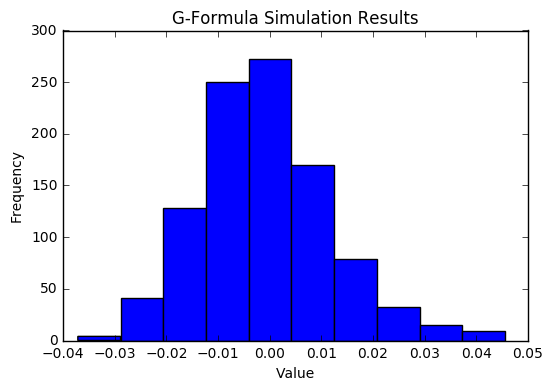

In [49]:
%matplotlib inline
plt.hist(results_g_formula)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

(array([   1.,    1.,    1.,    1.,  992.,    0.,    1.,    1.,    0.,    2.]),
 array([-0.31307606, -0.24472614, -0.17637623, -0.10802631, -0.03967639,
         0.02867353,  0.09702344,  0.16537336,  0.23372328,  0.3020732 ,
         0.37042311]),
 <a list of 10 Patch objects>)

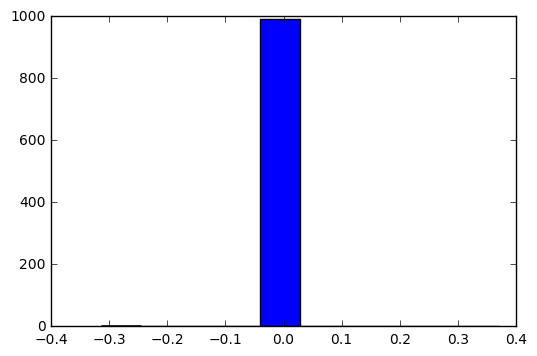

In [41]:
plt.hist(results_dr_estimator)
plt.title("G-Formula Simulation Results")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.savefig('g-formula-sim.png', bbox_inches='tight')

In [422]:
plotly.tools.set_credentials_file(username='mbreitmeyer2', api_key='dw8PAElGZsFlMHarQZcb')

fig = plt.figure()
data = [go.Histogram(x = results_g_formula)]
py.iplot(data)


NameError: name 'results_g_formula' is not defined

In [86]:
fig = plt.figure()
data = [go.Histogram(x = results_dr_estimator)]
py.iplot(data)

In [938]:
trace1 = go.Histogram(
    x=results_g_form_df.difference,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_dr_bin_df.difference,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram')

In [1136]:
results_effect_df2

trace1 = go.Histogram(
    x=results_effect_df2.differenceg,
    opacity=0.75, 
    name = "G-formula"
)
trace2 = go.Histogram(
    x=results_effect_df2.differencedr,
    opacity=0.75, 
    name = "DR estimator"
)

data = [trace2, trace1]
layout = go.Layout(barmode='overlay', xaxis = dict(range = [-0.1, 0.1]))

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid_histogram_weffect')

In [942]:
print(np.mean(np.absolute(results_dr_bin_df.difference)))
print(np.mean(np.absolute(results_g_form_df.difference)))

0.030767222441063457
0.015947726700425487


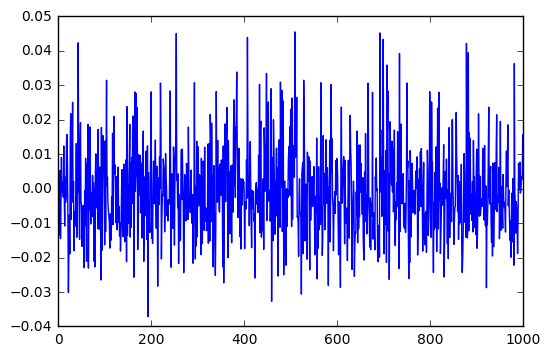

In [42]:
plt.plot(results_g_formula)

In [96]:
results_g_form_df

trace1 = go.Scatter(
    x=results_g_form_df.difference,
    name='G Form'
)
trace2 = go.Scatter(
    x=results_dr_bin_df.difference,
    name='LR DR'
)
data = [trace1, trace2]
layout = go.Layout(xaxis = dict(range = [-0.1, 0.1]))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

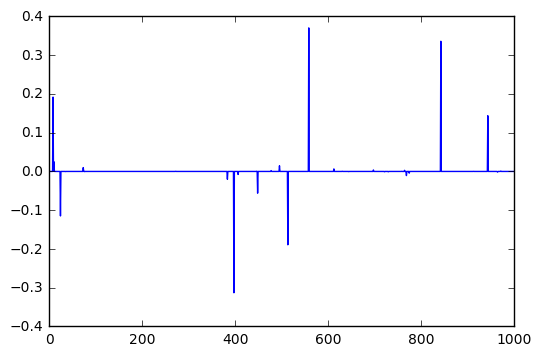

In [43]:
plt.plot(results_dr_estimator)

In [301]:
len(df+1)

12000

In [303]:
len(df)+1

12001